# <center>Exercise 7 Longevity Factors Exploration</center>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from scipy.stats import uniform, randint, expon
from sklearn.utils.fixes import loguniform

#for missing value imputation
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, BiScaler
from sklearn.ensemble import ExtraTreesClassifier

# for data preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, SMOTENC, KMeansSMOTE

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold, RepeatedStratifiedKFold

# for modeling
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# for evaluation
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report, make_scorer, f1_score
from sklearn.metrics import confusion_matrix


In [3]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

**Objectives:**
- Practise different data imputaion methods. 
- Practise feature selection. 
- Try different classifiers. 
- Explore the key factors of the elder longevity. 

**Data Source:** From Professor

# 1 Data Understanding

## 1.1 Load Data

In [4]:
data = pd.read_excel('original_data.xlsx')
data.shape

(2151, 87)

**<font size=4>Description of Variables</font>**

**Generial Variables**</br>

`id`	ID, province code +given No. + year of the wave of the very first interview	\
`srhealth`	self-reported health	1:very good, 2:good, 3:so so, 4:bad, 5:very bad
`din1`	death in 1 year after baseline	0=no, 1=yes, 9=lost in 1 years
`din3`	death in 3 year after baseline	0=no, 1=yes, 9=lost in 3 years
`din5`	death in 5 year after baseline	0=no, 1=yes, 9=lost in 5 years
`Northsouth`	north or south	0=south 1=north
`lfsatisfy`	self-reported quality of life (life satisfactory)	1:very good, 2:good, 3:soso, 4:bad, 5: very bad
`survival_bas`	survival time from survey of baseline to death for the decedents, or the last contact for those lost to follow up, or the last survery in 2014 for those alive	range 0-6
`censor`	actually means dead or not	1=died; 0=not died (alive or missing)
`lost`	lost or not	1=lost; 0=not lost (died or alive)
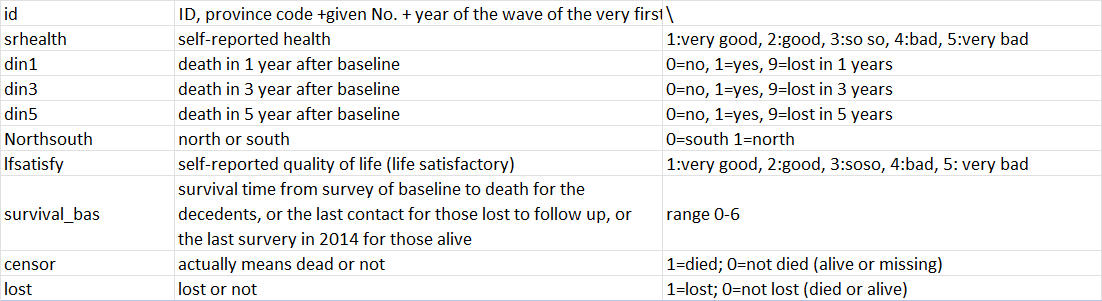

**Demographics**</br>

`trueage`	validated age	range: 39-116 years old
`gender`	gender	1: male; 0: female
`ethnicity`	ethnic group	1: Han; 0: others (minority)
`residence`	Category of residence of the interviewee	1: urban (city or town);  2: rural
`edu`	schooling of years	range: 0-24
`occupation`	Main occupation before age 60	0: non-manual; 1: manual
`coresidence`	Co-residence of interviewee	1: with household member; 2: alone; 3: in an institution
`marital`	marital status	1: married; 2: others (including seperated, widowed, divorced, never married)
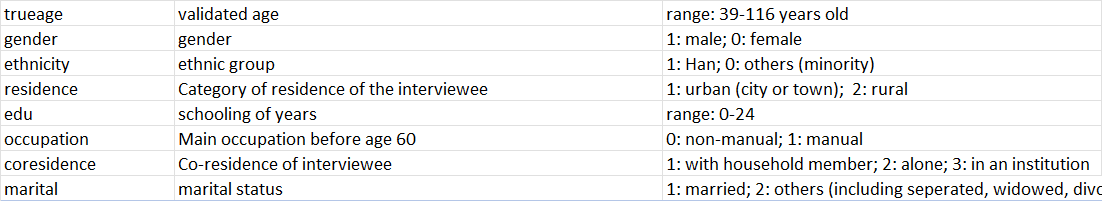

**Healthy lifestyle factors**</br>

`smkl`	smoking status	1: never smoke; 2: former smoker; 3: light current smoker (<20 zhi/day); 4: heavy current smoker (>=20 zhi/day)
`dril`	drinking status	1:never; 2:former; 3:current & light <=25g alcohol (for male)/15g(for female) per day; 4:current & heavy >25g(for male)/15g(for female)
`pa`	regularly physical activity at present	1: current & start age<50; 2: current & start age>=50 ; 3: former; 4: never
`fruit`	how often eat fresh fruit at present?	2=everyday (or except for winter), 1=occasionally, 0=rarely or never
veg	how often eat vegetables at present?	
`garlic`	how often eat garlic at present?	2=everyday, 1=occasionally, 0=rarely or never
`meat`	how often eat meat at present?	
`fish`	how often eat fish at present?	
`egg`	how often eat eggs at present?	
`bean`	how often eat food made from beans at present?	
`tea`	how often drink tea at present?	
`sugar`	how often eat sugar at present?	0=everyday, 1=occasionally, 2=rarely or neve
`saltveg`	how often eat salt-preserved vegetables at present
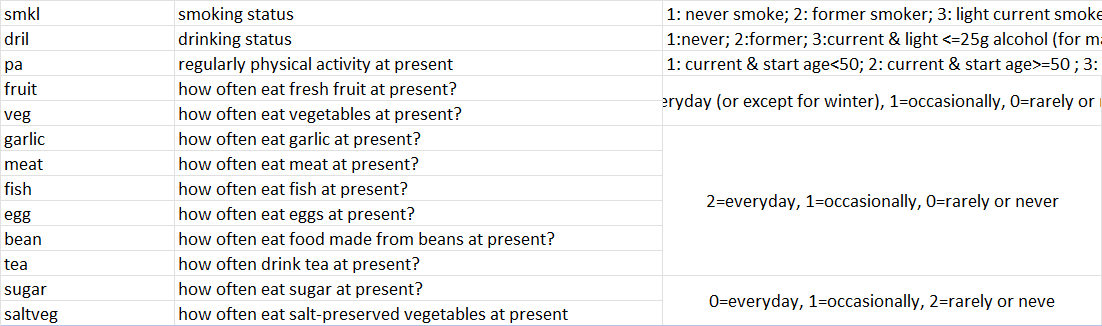

**Leisure activities**</br>
`leisure` 	sum of the above seven activities	"range: 5-21
(note: if >2 activities were missing, leisure was defined as missing [17, 0.04% of total sample]"
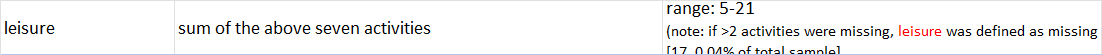

**Activities of daily living**</br>
`adl`	category of ADL	"1: yes (adl_sum>0); 
0: no (adl_sum=0)
(note: if >1 items were missing, adl was defined as missing [13, 0.03% of total sample])"
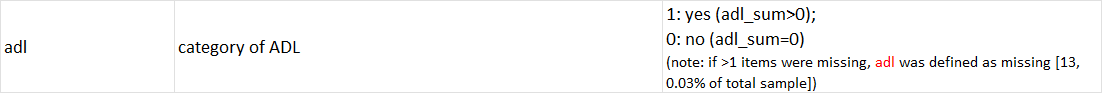

**Disease**</br>
`diseasetime`	# of times suffering from serious illness in the past two years	range: 0-20; 88=bedridden all the year around
`hypertension`	suffering from hypertension, and disability in daily life	"1=have this diease, with severe impact on life;
2=have this diease, without severe impact (including more or less, or no) on life;
3=don't have this diease"
`diabetes`	 糖尿病	
`heartdisea`	heart disease 心脏病	
`strokecvd`	stroke or cvd 中风及脑血管疾病	
`copd`	bronchitis 支气管炎, emphysema 肺气肿, pneumonia 肺炎, asthma 哮喘	
`tb`	tuberculosis  肺结核病	
`cataract`	cataract  白内障	
`glaucoma`	glaucoma  青光眼	
`cancer`	cancer	
`ulcer`	gastric or duodenal ulcer  十二指肠溃疡	
`parkinson`	parkinson's diease  帕金森氏病	
`bedsore`	bedsore 褥疮
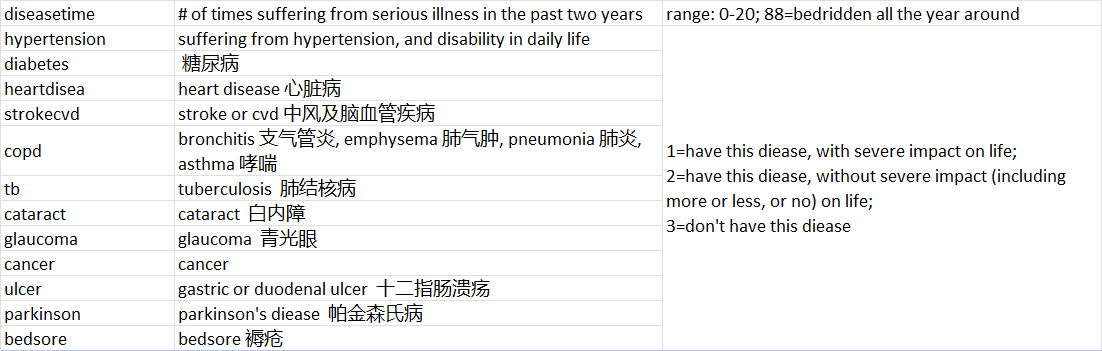

**Cognition function (measured by MMSE)**</br>
`ci`	the score of MMSE, sum of orientation, naming food, registration, attention and calculation, copy figure, recall, Language. The higher the better in cognition	"0-30
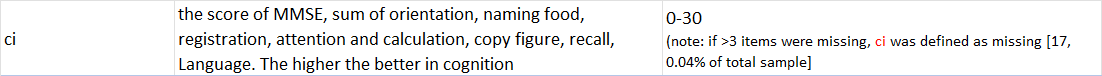

**psychological well-being**</br>
`psycho1`	look on the bright side of things	5=always, 4=often, 3=sometimes, 2=seldom, 1=never
`psycho2`	keep my belongings neat and clean	
`psycho5`	make own decision	
`psycho7`	be happy as younger	
`psycho3`	feel fearful or anxious	1=always, 2=often, 3=sometimes, 4=seldom, 5=never
`psycho4`	feel lonely and isolated	
`psycho6`	feel useless with age	
`psycho`	sum of the above seven items	"range: 7-35 
(note: if >2 items were missing, psycho was defined as missing [5414, 12.46% of total sample].)"
`psy_miss`	the number of missing components for psycho	range: 0-7
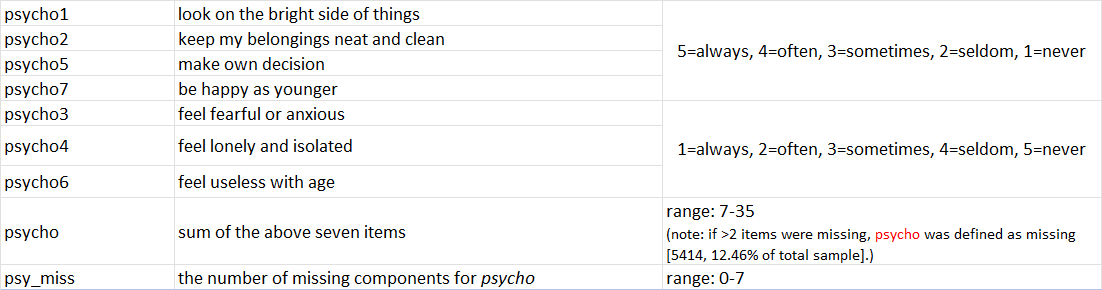

**Physical examination**</br>
weight		range: 16-170kg
sbp	systolic blood pressure	range: 39-250
dbp	diastolic blood pressure	range: 18-200
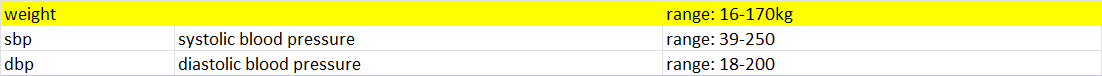

**Biomarker**</br>
alb	albumin  血清白蛋白	"1%	:26.9	，99%:	51.9"
bun	Blood urea nitrogen	"1%	:3.17	，99%:	13.75"
cho	total cholesterol	"1%	:2.21	，99%:	6.93"
crea	plasma creatine 血浆肌酸	"1%	:42	，99%:	183"
crphs	high sensitive crp	"1%	:0.08	，99%:	40.8"
glu	glucose 血糖	"1%	:1.27	，99%:	11.39"
gsp	glycolated plasma protein 乙醇化血浆蛋白	"1%	:169.2	，99%:	392.4"
hdlc	high-density lipoprotein cho	"1%	:0.59	，99%:	2.33"
ldlc	low-density lipoprotein cho	"1%	:0.87	，99%:	4.88"
tg	triglyceride 甘油三酸酯	"1%	:0.28	，99%:	3.77"
ua	urea acid 尿酸	"1%	:135.8	，99%:	556.4"
sod	superoxide dismutase	"1%	:31.29	，99%:	87.37"
vd3	25-oh-vitamind3	"1%	:10.85	，99%:	100.73"
mda	malondialdehyde 丙二醛；脂质过氧化产物；丙二酰	"1%	:2.03	，99%:	18.06"
vitb12	vitamin b12	"1%	:121	，99%:	991"
ualb	urine microalbumin	"1%	:0	，99%:	310.03"
ucr	urine creatinine	"1%	:8.41	，99%:	347.49"
ualbbyucr	ualb/ucr ratio	"1%	:0	，99%:	568.37"
wbc	white blood cell count	"1%	:2.8	，99%:	11.45"
lymph	lymphocyte count	"1%	:11.8	，99%:	54.9"
lymph_a	percentage of lymhocytes	"1%	:0.6	，99%:	3.9"
rbc	red blood cell count	"1%	:2.52	，99%:	8.83"
hgb	hemoglobin	"1%	:65	，99%:	187"
hct	erythrocyte hematocrit	"1%	:23.4	，99%:	72.8"
mcv	erythrocyte mean corpuscular volume	"1%	:66.3	，99%:	112.6"
mch	erythrocyte mean corpuscular hemoglobin	"1%	:16.4	，99%:	36.1"
mchc	erythrocyte mean corpuscular hemoglobin concentration 	"1%	:185	，99%:	358"
plt	platelet count	"1%	:54	，99%:	499"
mpv	mean platelet volume	"1%	:6.9	，99%:	13.3"
pdw	platelet distribution width	"1%	:10.4	，99%:	19.2"
pct	plateletocrit	"1%	:0.058	，99%:	0.457"
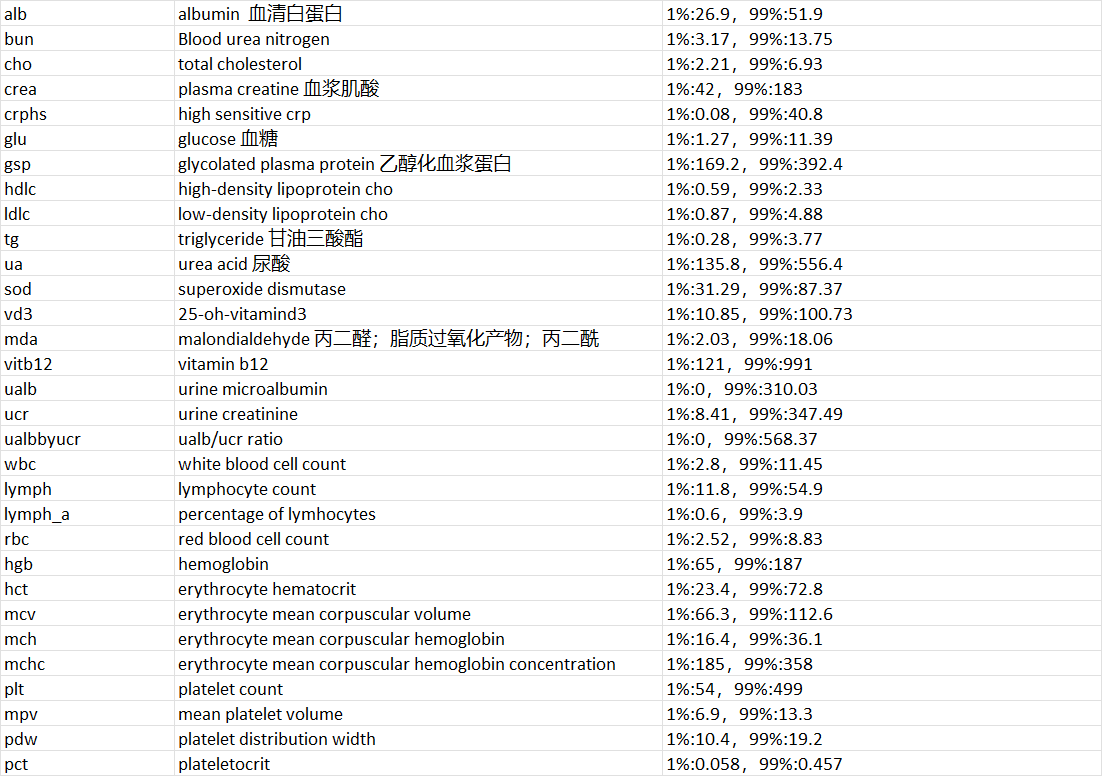


### 1.2 Determine a label

Because this task is to figure out the longevity factors, the label should be 'din1', 'din3', 'din5' or 'censor' based on the variable description above. Visualize the data distribution of these variables.

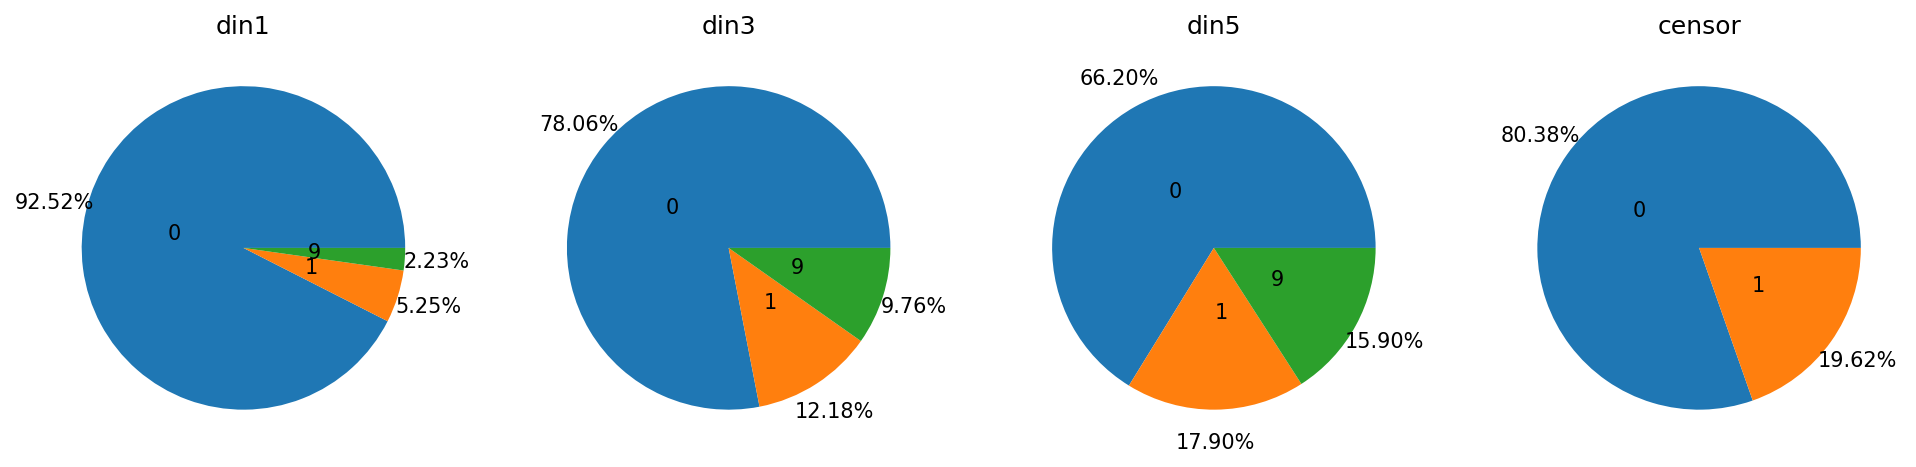

In [5]:
# Review the class distribution in each one

sizes1 = data.din1.value_counts()
labels1 = list(data.din1.value_counts().index)

sizes2 = data.din3.value_counts()
labels2 = list(data.din3.value_counts().index)

sizes3 = data.din5.value_counts()
labels3 = list(data.din5.value_counts().index)

sizes4 = data.censor.value_counts()
labels4 = list(data.censor.value_counts().index)


fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(16,8), dpi=150)

ax1.pie(sizes1, labels=labels1, autopct='%1.2f%%',
       pctdistance=1.2, labeldistance=.4)
ax1.set_title('din1')

ax2.pie(sizes2, labels=labels2, autopct='%1.2f%%',
       pctdistance=1.2, labeldistance=.4)
ax2.set_title('din3')

ax3.pie(sizes3, labels=labels3, autopct='%1.2f%%',
       pctdistance=1.2, labeldistance=.4)
ax3.set_title('din5')

ax4.pie(sizes4, labels=labels4, autopct='%1.2f%%',
       pctdistance=1.2, labeldistance=.4)
ax4.set_title('censor')

plt.show()

In [6]:
# Check any missing values in these variables
labelOptions = ['din1', 'din3', 'din5', 'censor']
for l in labelOptions:
    result = data[l].isnull().sum()
    print(f'{l} has null value: {result}')

din1 has null value: 0
din3 has null value: 0
din5 has null value: 0
censor has null value: 0


>Note:
>- These four variables have no missing values.
>- din1, din3, din5 has three classes. The class 9 stands for lost people, we don't know they are alive or not.
>- 'censor' has two classes, 0 means alive or missing; 1 is for the died. As there are two cases in class 0, this could cause the class 0 unclear. Will not use this variable as label.
>- As din3 record people whose death was in 3 year after baseline, not too far or closed.But will drop the records that are in class 9.

## 2 EDA & Data Preprocessing

### 2.1 Data Cleaning

In [7]:
# Remove irrelevant features for longevity factors study after din5 is set as label
data.drop(['id', 'din1', 'censor', 'din5', 'survival_bas', 'lost'], axis=1, inplace=True)
data.shape

(2151, 81)

In [8]:
# Keep class 0, 1 in din3, drop class9.
data = data[data['din3'].isin([0, 1])]
data.shape

(1941, 81)

<AxesSubplot:xlabel='trueage'>

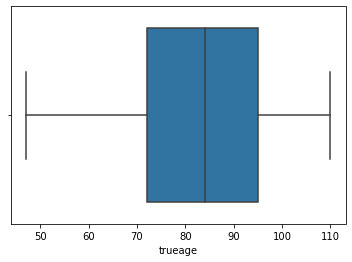

In [9]:
# Check age range of this dataset
sns.boxplot(data=data, x=data['trueage'])

In [10]:
# Drop people who are younger than 55, because this study focuses on longevity of the elder.
data = data[(data['trueage'] >= 55)]
data.shape

(1939, 81)

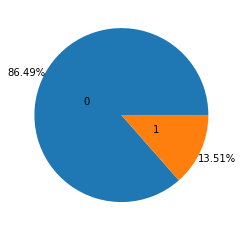

In [11]:
# Review the classes distribution now.

sizes = data.din3.value_counts()
labels = list(data.din3.value_counts().index)

plt.figure()
plt.pie(sizes, labels=labels, autopct='%1.2f%%',
       pctdistance=1.2, labeldistance=.4)

plt.show()

In [12]:
# Check the missing values in all variables.

variables = list(data.columns)

for v in variables:
    na = data[v].isnull().sum()
    print(f'{v} has null value: {na}')

alb has null value: 0
bun has null value: 0
cho has null value: 0
crea has null value: 0
crphs has null value: 0
glu has null value: 0
gsp has null value: 0
hdlc has null value: 0
ldlc has null value: 0
tg has null value: 0
ua has null value: 0
sod has null value: 10
vd3 has null value: 9
mda has null value: 9
vitb12 has null value: 0
ualb has null value: 177
ucr has null value: 177
ualbbyucr has null value: 177
wbc has null value: 58
lymph has null value: 61
lymph_a has null value: 62
rbc has null value: 61
hgb has null value: 58
hct has null value: 78
mcv has null value: 60
mch has null value: 60
mchc has null value: 62
plt has null value: 57
mpv has null value: 94
pdw has null value: 93
pct has null value: 114
northsouth has null value: 0
trueage has null value: 0
gender has null value: 0
ethnicity has null value: 0
coresidence has null value: 16
edu has null value: 14
marital has null value: 5
residence has null value: 0
occupation has null value: 0
weight has null value: 55
smkl h

**Handle missing value of 'diseasetime'**

In [13]:
# Sort out some diseases were reported, but 'diseasetime' is null. That is incorrect.

diseases = ['hypertension', 'diabetes', 'heartdisea', 'strokecvd', 'copd', 'tb', 'cataract', 'glaucoma',
            'cancer', 'ulcer', 'parkinson', 'bedsore']

for d in diseases:
    error = data[((data[d] == 1 ) | (data[d] == 2)) & (data.diseasetime.isnull() == True)]
    print(error.shape)
    print(error.index)

(4, 81)
Int64Index([273, 908, 1316, 1395], dtype='int64')
(0, 81)
Int64Index([], dtype='int64')
(2, 81)
Int64Index([952, 1344], dtype='int64')
(1, 81)
Int64Index([273], dtype='int64')
(2, 81)
Int64Index([1344, 2019], dtype='int64')
(0, 81)
Int64Index([], dtype='int64')
(1, 81)
Int64Index([1524], dtype='int64')
(0, 81)
Int64Index([], dtype='int64')
(0, 81)
Int64Index([], dtype='int64')
(0, 81)
Int64Index([], dtype='int64')
(1, 81)
Int64Index([269], dtype='int64')
(0, 81)
Int64Index([], dtype='int64')


In [14]:
data.diseasetime.value_counts()

0.0     1659
1.0      183
2.0       42
88.0      11
3.0       10
5.0        2
4.0        1
20.0       1
9.0        1
6.0        1
Name: diseasetime, dtype: int64

In [15]:
# Replace the null value of these to 1 because there are some diseases reported, and 1 is the mode after 0.

index = [273, 908, 1316, 1395, 952, 1344, 2019, 1524, 269]

for n in index:
    data.at[n, 'diseasetime'] = 1
    
data.diseasetime.value_counts()

0.0     1659
1.0      192
2.0       42
88.0      11
3.0       10
5.0        2
4.0        1
20.0       1
9.0        1
6.0        1
Name: diseasetime, dtype: int64

In [16]:
# Sort out no disease was reported, but 'diseasetime' is null. 

for d in diseases:
    error1 = data[(data[d] == 3 ) & (data.diseasetime.isnull() == True)]
    print(error1.shape)
    print(error1.index)

(19, 81)
Int64Index([  54,   56,  151,  175,  178,  208,  268,  879,  884,  890,  927,
             932,  940,  941,  945, 1012, 1014, 1794, 1993],
           dtype='int64')
(19, 81)
Int64Index([  54,   56,  151,  175,  178,  208,  268,  879,  884,  890,  927,
             932,  940,  941,  945, 1012, 1014, 1794, 1993],
           dtype='int64')
(19, 81)
Int64Index([  54,   56,  151,  175,  178,  208,  268,  879,  884,  890,  927,
             932,  940,  941,  945, 1012, 1014, 1794, 1993],
           dtype='int64')
(19, 81)
Int64Index([  54,   56,  151,  175,  178,  208,  268,  879,  884,  890,  927,
             932,  940,  941,  945, 1012, 1014, 1794, 1993],
           dtype='int64')
(19, 81)
Int64Index([  54,   56,  151,  175,  178,  208,  268,  879,  884,  890,  927,
             932,  940,  941,  945, 1012, 1014, 1794, 1993],
           dtype='int64')
(19, 81)
Int64Index([  54,   56,  151,  175,  178,  208,  268,  879,  884,  890,  927,
             932,  940,  941,  945, 1012, 1

In [17]:
# Replace these null value to 0.

index = [54,   56,  151,  175,  178,  208,  268,  879,  884,  890,  927,
             932,  940,  941,  945, 1012, 1014, 1794, 1993]

for n in index:
    data.at[n, 'diseasetime'] = 0
    
data.diseasetime.value_counts()

0.0     1678
1.0      192
2.0       42
88.0      11
3.0       10
5.0        2
4.0        1
20.0       1
9.0        1
6.0        1
Name: diseasetime, dtype: int64

In [18]:
# Review any null value of 'diseasetime'

data[(data.diseasetime.isnull() == True)]

,alb,bun,cho,crea,crphs,glu,gsp,hdlc,ldlc,tg,...,adl,leisure,ci,handneck,handback,standup,pickup,hear,cancer,din3


Reset index for next task

In [19]:
data.reset_index(inplace=True)
data

,index,alb,bun,cho,crea,crphs,glu,gsp,hdlc,ldlc,...,adl,leisure,ci,handneck,handback,standup,pickup,hear,cancer,din3
0,0,48.200001,4.32,5.51,68,0.250000,4.24,221.39999,1.05,3.66,...,0.0,7,16,3.0,3.0,1.0,1.0,1.0,3,0
1,1,34.500000,9.94,3.75,93,0.990000,3.18,180.89999,1.30,2.28,...,0.0,11,30,3.0,3.0,1.0,1.0,1.0,3,0
2,2,43.700001,8.00,3.25,119,6.770000,4.01,244.80000,0.83,2.04,...,0.0,11,30,3.0,3.0,1.0,1.0,1.0,3,0
3,3,41.799999,14.57,4.12,151,49.900002,3.86,242.10001,1.19,2.51,...,0.0,10,30,3.0,3.0,1.0,2.0,1.0,3,0
4,4,36.900002,4.17,3.98,55,6.410000,3.92,202.50000,0.79,2.64,...,0.0,10,30,3.0,3.0,1.0,1.0,3.0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1934,2142,38.599998,5.01,3.89,72,9.620000,4.20,247.80000,1.14,2.38,...,0.0,7,5,3.0,3.0,2.0,2.0,2.0,3,1
1935,2143,39.200001,5.17,4.35,75,4.800000,4.29,245.10001,1.73,2.35,...,0.0,9,23,3.0,3.0,2.0,2.0,2.0,3,0
1936,2144,37.099998,4.88,4.25,65,0.910000,3.19,230.89999,0.81,2.74,...,0.0,7,15,3.0,3.0,2.0,2.0,2.0,3,1
1937,2148,43.000000,4.00,3.60,71,3.950000,2.88,231.80000,1.32,1.93,...,0.0,9,23,3.0,3.0,1.0,1.0,1.0,3,0


In [20]:
data.drop(['index'], axis=1, inplace=True)
data

,alb,bun,cho,crea,crphs,glu,gsp,hdlc,ldlc,tg,...,adl,leisure,ci,handneck,handback,standup,pickup,hear,cancer,din3
0,48.200001,4.32,5.51,68,0.250000,4.24,221.39999,1.05,3.66,1.76,...,0.0,7,16,3.0,3.0,1.0,1.0,1.0,3,0
1,34.500000,9.94,3.75,93,0.990000,3.18,180.89999,1.30,2.28,0.37,...,0.0,11,30,3.0,3.0,1.0,1.0,1.0,3,0
2,43.700001,8.00,3.25,119,6.770000,4.01,244.80000,0.83,2.04,0.83,...,0.0,11,30,3.0,3.0,1.0,1.0,1.0,3,0
3,41.799999,14.57,4.12,151,49.900002,3.86,242.10001,1.19,2.51,0.92,...,0.0,10,30,3.0,3.0,1.0,2.0,1.0,3,0
4,36.900002,4.17,3.98,55,6.410000,3.92,202.50000,0.79,2.64,1.22,...,0.0,10,30,3.0,3.0,1.0,1.0,3.0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1934,38.599998,5.01,3.89,72,9.620000,4.20,247.80000,1.14,2.38,0.81,...,0.0,7,5,3.0,3.0,2.0,2.0,2.0,3,1
1935,39.200001,5.17,4.35,75,4.800000,4.29,245.10001,1.73,2.35,0.59,...,0.0,9,23,3.0,3.0,2.0,2.0,2.0,3,0
1936,37.099998,4.88,4.25,65,0.910000,3.19,230.89999,0.81,2.74,1.55,...,0.0,7,15,3.0,3.0,2.0,2.0,2.0,3,1
1937,43.000000,4.00,3.60,71,3.950000,2.88,231.80000,1.32,1.93,0.78,...,0.0,9,23,3.0,3.0,1.0,1.0,1.0,3,0


**Handle missing value of 'edu'**

In [21]:
# Sort out people who live in rural area and edu is null.

eduR = data[(data.edu.isnull() == True) & (data.residence == 2)]
eduR

,alb,bun,cho,crea,crphs,glu,gsp,hdlc,ldlc,tg,...,adl,leisure,ci,handneck,handback,standup,pickup,hear,cancer,din3
404,37.299999,5.69,5.04,51,0.07,3.80,207.89999,1.71,3.05,0.62,...,1.0,7,3,3.0,3.0,3.0,3.0,4.0,3,1
485,38.500000,6.51,2.98,76,0.15,4.13,258.29999,1.06,1.84,0.17,...,1.0,11,0,1.0,3.0,2.0,2.0,4.0,3,1
872,35.200001,4.32,4.88,55,4.35,4.50,206.10001,1.13,3.40,0.78,...,1.0,7,3,3.0,3.0,2.0,2.0,3.0,3,1
885,35.200001,9.00,3.88,99,3.06,5.20,205.70000,1.21,2.39,0.62,...,0.0,11,25,3.0,3.0,1.0,2.0,1.0,3,0
896,26.400000,7.64,2.78,74,0.23,6.56,210.70000,0.50,1.29,2.18,...,0.0,14,29,3.0,3.0,1.0,1.0,1.0,3,0
1205,46.200001,7.94,4.78,96,0.35,5.84,257.39999,1.24,2.41,2.48,...,0.0,13,29,3.0,3.0,1.0,1.0,1.0,3,0
1380,36.799999,8.42,5.23,105,0.99,4.99,207.89999,1.28,3.55,0.89,...,0.0,11,21,3.0,3.0,1.0,1.0,2.0,3,0
1382,27.299999,6.62,3.82,69,0.29,4.84,208.80000,1.42,1.96,0.97,...,0.0,8,25,3.0,3.0,1.0,1.0,1.0,3,0
1931,38.900002,4.64,4.55,67,2.17,3.07,190.10001,1.12,2.93,1.10,...,0.0,13,28,3.0,3.0,2.0,2.0,1.0,3,0
1936,37.099998,4.88,4.25,65,0.91,3.19,230.89999,0.81,2.74,1.55,...,0.0,7,15,3.0,3.0,2.0,2.0,2.0,3,1


In [22]:
# Sort out people who live in urban area and edu is null.

eduU = data[(data.edu.isnull() == True) & (data.residence == 1)]
eduU

,alb,bun,cho,crea,crphs,glu,gsp,hdlc,ldlc,tg,...,adl,leisure,ci,handneck,handback,standup,pickup,hear,cancer,din3
413,44.299999,5.27,3.25,64,0.34,4.19,224.10001,0.96,1.75,1.18,...,1.0,7,0,4.0,4.0,3.0,3.0,4.0,3,1
989,38.799999,8.69,4.63,100,0.85,5.49,279.00000,0.95,3.28,0.88,...,0.0,9,22,3.0,3.0,1.0,1.0,1.0,3,1
1247,46.799999,13.16,6.41,79,6.57,3.15,275.39999,1.45,4.51,1.00,...,1.0,7,5,3.0,3.0,3.0,3.0,3.0,3,1
1254,43.500000,7.72,4.70,114,0.38,5.81,251.10001,1.51,2.77,0.92,...,0.0,7,6,3.0,3.0,1.0,1.0,3.0,3,0


<AxesSubplot:xlabel='edu'>

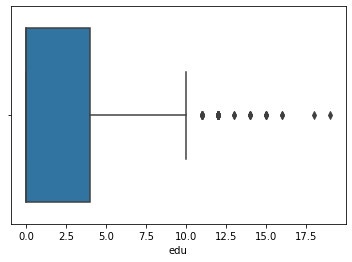

In [23]:
# Review edu data distrubition

sns.boxplot(data=data, x=data['edu'])

In [24]:
data.edu.value_counts()

0.0     1174
6.0      144
3.0      114
5.0      106
4.0       87
2.0       85
9.0       61
7.0       37
8.0       28
12.0      27
1.0       26
10.0      12
11.0      10
14.0       4
15.0       4
16.0       2
13.0       2
19.0       1
18.0       1
Name: edu, dtype: int64

In [25]:
# Replace edu is null of people who live in rural area to 0.

index = list(eduR.index)

for e in index:
    data.at[e, 'edu'] = 0
    
data.edu.value_counts()  

0.0     1184
6.0      144
3.0      114
5.0      106
4.0       87
2.0       85
9.0       61
7.0       37
8.0       28
12.0      27
1.0       26
10.0      12
11.0      10
14.0       4
15.0       4
16.0       2
13.0       2
19.0       1
18.0       1
Name: edu, dtype: int64

In [26]:
# Replace edu is null of people who live in urban area to 6.

index1 = list(eduU.index)

for n in index1:
    data.at[n, 'edu'] = 6
    
data.edu.value_counts()

0.0     1184
6.0      148
3.0      114
5.0      106
4.0       87
2.0       85
9.0       61
7.0       37
8.0       28
12.0      27
1.0       26
10.0      12
11.0      10
14.0       4
15.0       4
16.0       2
13.0       2
19.0       1
18.0       1
Name: edu, dtype: int64

In [27]:
data[data.edu.isnull() == True]

,alb,bun,cho,crea,crphs,glu,gsp,hdlc,ldlc,tg,...,adl,leisure,ci,handneck,handback,standup,pickup,hear,cancer,din3


**Handle missing value of 'psycho', 'srhealth', 'lfsatisfy'**

In [28]:
data.psycho.value_counts()

27.0    178
24.0    160
25.0    159
26.0    153
28.0    141
29.0    137
23.0    135
22.0    114
21.0     89
30.0     79
31.0     74
20.0     72
33.0     65
32.0     44
19.0     38
18.0     32
17.0     15
34.0     15
35.0     14
16.0     13
14.0      7
15.0      6
13.0      2
11.0      2
12.0      1
Name: psycho, dtype: int64

In [29]:
# Sort people whose psycho is null but Ifsatisfy is equal to or greater than 2.

sl2 = data[(data.lfsatisfy <= 2) & (data.psycho.isnull() == True)]
sl2

,alb,bun,cho,crea,crphs,glu,gsp,hdlc,ldlc,tg,...,adl,leisure,ci,handneck,handback,standup,pickup,hear,cancer,din3
78,33.500000,5.54,3.83,61,1.50,4.62,167.39999,1.04,2.21,1.28,...,1.0,9,9,3.0,3.0,2.0,2.0,1.0,3,1
96,37.599998,8.21,3.07,57,1.98,5.31,210.60001,0.96,1.72,0.85,...,0.0,8,7,3.0,3.0,2.0,2.0,3.0,3,1
204,39.700001,4.32,3.42,56,0.20,4.41,218.70000,1.53,1.57,0.70,...,0.0,7,11,3.0,3.0,1.0,2.0,3.0,3,0
304,35.900002,7.34,5.25,60,1.93,3.97,232.20000,1.09,3.80,0.79,...,1.0,9,0,3.0,3.0,2.0,3.0,4.0,3,0
315,31.700001,4.90,4.60,116,5.29,3.28,221.39999,0.76,3.49,0.76,...,1.0,17,0,3.0,3.0,1.0,1.0,3.0,3,0
325,33.700001,7.87,3.50,70,5.07,4.64,189.00000,1.08,2.22,0.45,...,1.0,7,2,3.0,3.0,2.0,2.0,3.0,3,0
459,43.700001,7.74,4.99,80,2.73,4.39,249.30000,1.43,3.11,0.98,...,0.0,11,10,3.0,3.0,1.0,1.0,3.0,3,0
481,42.200001,7.56,6.47,47,0.57,3.66,214.20000,2.40,3.75,0.70,...,1.0,9,17,3.0,3.0,3.0,3.0,3.0,3,0
495,39.799999,5.48,4.63,38,0.53,4.32,225.00000,1.54,2.78,0.68,...,1.0,8,0,3.0,3.0,3.0,3.0,4.0,3,0
510,40.099998,12.09,4.51,97,0.15,4.01,252.00000,2.22,2.14,0.32,...,1.0,11,13,3.0,3.0,2.0,2.0,4.0,3,0


In [30]:
# Replace these people psycho from null to 28.

index2 = list(sl2.index)

for n in index2:
    data.at[n, 'psycho'] = 28
    
data.psycho.value_counts()

27.0    178
28.0    168
24.0    160
25.0    159
26.0    153
29.0    137
23.0    135
22.0    114
21.0     89
30.0     79
31.0     74
20.0     72
33.0     65
32.0     44
19.0     38
18.0     32
17.0     15
34.0     15
35.0     14
16.0     13
14.0      7
15.0      6
13.0      2
11.0      2
12.0      1
Name: psycho, dtype: int64

In [31]:
# Sort people whose psycho is null but Ifsatisfy is equal to 3.

sl3 = data[(data.lfsatisfy == 3 ) & (data.psycho.isnull() == True)]
sl3

,alb,bun,cho,crea,crphs,glu,gsp,hdlc,ldlc,tg,...,adl,leisure,ci,handneck,handback,standup,pickup,hear,cancer,din3
43,21.500000,6.420000,2.35,50,19.590000,2.740000,132.30000,0.51,1.53,0.68,...,1.0,7,0,3.0,4.0,3.0,3.0,4.0,3,1
50,35.700001,5.440000,5.83,54,0.180000,4.420000,255.60001,1.67,3.78,0.83,...,1.0,11,0,3.0,3.0,3.0,3.0,4.0,3,1
51,27.000000,2.930000,3.11,65,13.140000,6.500000,270.00000,0.56,1.96,1.29,...,1.0,7,0,4.0,4.0,3.0,3.0,4.0,3,1
140,48.299999,4.050000,5.84,55,0.230000,5.410000,255.60001,1.23,3.51,2.43,...,0.0,12,17,1.0,3.0,1.0,2.0,1.0,3,0
318,30.400000,11.260000,2.67,95,33.090000,5.980000,193.50000,1.36,1.18,0.29,...,1.0,8,20,3.0,3.0,2.0,1.0,3.0,3,0
692,37.799999,9.229999,2.69,85,0.640000,4.640000,228.60001,0.90,1.46,0.72,...,0.0,8,17,3.0,3.0,1.0,1.0,3.0,3,0
780,29.500000,4.040000,2.56,50,3.910000,4.140000,192.60001,0.94,1.44,0.39,...,1.0,8,6,3.0,4.0,3.0,3.0,3.0,3,1
799,38.500000,7.100000,2.59,63,0.260000,4.210000,213.30000,1.24,1.10,0.56,...,1.0,8,23,3.0,3.0,1.0,1.0,1.0,3,0
830,42.299999,4.710000,3.92,66,1.070000,5.430000,218.70000,1.34,2.28,0.66,...,1.0,9,23,3.0,3.0,1.0,1.0,3.0,3,0
919,39.900002,5.710000,6.34,64,17.940001,4.620000,251.10001,1.08,4.88,0.83,...,1.0,7,3,3.0,4.0,3.0,3.0,3.0,3,1


In [32]:
# Replace these people psycho from null to 21.

index3 = list(sl3.index)

for n in index3:
    data.at[n, 'psycho'] = 21
    
data.psycho.value_counts()

27.0    178
28.0    168
24.0    160
25.0    159
26.0    153
29.0    137
23.0    135
22.0    114
21.0    112
30.0     79
31.0     74
20.0     72
33.0     65
32.0     44
19.0     38
18.0     32
17.0     15
34.0     15
35.0     14
16.0     13
14.0      7
15.0      6
13.0      2
11.0      2
12.0      1
Name: psycho, dtype: int64

In [33]:
# Sort people whose psycho is null but Ifsatisfy is equal to or greater than 4.

sl4 = data[(data.lfsatisfy >= 4 ) & (data.psycho.isnull() == True)]
sl4

,alb,bun,cho,crea,crphs,glu,gsp,hdlc,ldlc,tg,...,adl,leisure,ci,handneck,handback,standup,pickup,hear,cancer,din3
706,43.400002,6.85,6.54,77,0.30,4.25,262.79999,2.01,3.76,1.69,...,0.0,11,12,3.0,3.0,1.0,1.0,2.0,3,0
708,38.200001,5.89,4.54,69,12.79,3.97,225.89999,0.94,3.03,1.26,...,0.0,9,10,2.0,3.0,1.0,2.0,2.0,3,0
834,35.799999,7.23,3.35,69,0.47,7.82,245.70000,0.98,2.04,0.73,...,1.0,7,15,3.0,3.0,2.0,2.0,3.0,3,1
1033,35.099998,6.95,4.41,81,13.18,4.02,223.20000,0.91,2.99,1.13,...,1.0,9,16,4.0,4.0,2.0,3.0,4.0,3,1
1285,33.400002,7.28,3.05,110,0.83,1.74,216.00000,1.40,1.44,0.46,...,1.0,7,13,2.0,4.0,NaN,3.0,1.0,3,1
1817,38.599998,5.97,4.83,27,5.64,3.36,240.20000,1.90,2.71,0.48,...,0.0,8,2,3.0,3.0,2.0,2.0,2.0,3,0


In [34]:
# Replace these people psycho from null to 14.

index4 = list(sl4.index)

for n in index4:
    data.at[n, 'psycho'] = 14
    
data.psycho.value_counts()

27.0    178
28.0    168
24.0    160
25.0    159
26.0    153
29.0    137
23.0    135
22.0    114
21.0    112
30.0     79
31.0     74
20.0     72
33.0     65
32.0     44
19.0     38
18.0     32
17.0     15
34.0     15
35.0     14
16.0     13
14.0     13
15.0      6
13.0      2
11.0      2
12.0      1
Name: psycho, dtype: int64

In [35]:
# Review the null of psycho now

data.psycho.isnull().sum()

138

In [36]:
data.shape

(1939, 81)

In [37]:
# Remove 'trueage' and 'gender', because we will study the other factors that affect longevity, not age and gender.
# Remove all the Biomarker variables, because these can be reflected by relevant diseases or habits.

data.drop(['alb', 'bun', 'cho', 'crea', 'crphs', 'glu', 'gsp', 'hdlc', 'ldlc','tg', 'ua', 'sod', 'vd3', 'mda', 
            'vitb12', 'ualb', 'ucr', 'ualbbyucr', 'wbc', 'lymph', 'lymph_a', 'rbc', 'hgb', 'hct', 'mcv', 'mch', 'mchc', 
            'plt', 'mpv', 'pdw', 'pct','trueage', 'gender'], axis=1, inplace=True)
data.shape

(1939, 48)

In [38]:
# Drop glaucoma, ulcer, bedsore because they get null values over half the sample size. 
# Drop 'hypertension' as well, as it has 32 null values. 
# While 'sbp' & 'dbp' don't have null values. These two variables could be the indicators of hypertension.

data.drop(['glaucoma', 'ulcer', 'bedsore', 'hypertension'], axis=1, inplace=True)
data.shape

(1939, 44)

In [39]:
# Re-check the missing values in all variables
variables = list(data.columns)

for v in variables:
    na = data[v].isnull().sum()
    print(f'{v} has null value: {na}')

northsouth has null value: 0
ethnicity has null value: 0
coresidence has null value: 16
edu has null value: 0
marital has null value: 5
residence has null value: 0
occupation has null value: 0
weight has null value: 55
smkl has null value: 26
dril has null value: 14
pa has null value: 29
sbp has null value: 0
dbp has null value: 0
diseasetime has null value: 0
diabetes has null value: 22
heartdisea has null value: 26
strokecvd has null value: 22
copd has null value: 23
tb has null value: 26
cataract has null value: 23
parkinson has null value: 26
fruit has null value: 1
veg has null value: 8
meat has null value: 0
fish has null value: 0
egg has null value: 0
bean has null value: 0
saltveg has null value: 0
sugar has null value: 0
tea has null value: 0
garlic has null value: 0
srhealth has null value: 143
lfsatisfy has null value: 147
psycho has null value: 138
adl has null value: 4
leisure has null value: 0
ci has null value: 0
handneck has null value: 5
handback has null value: 5
stan

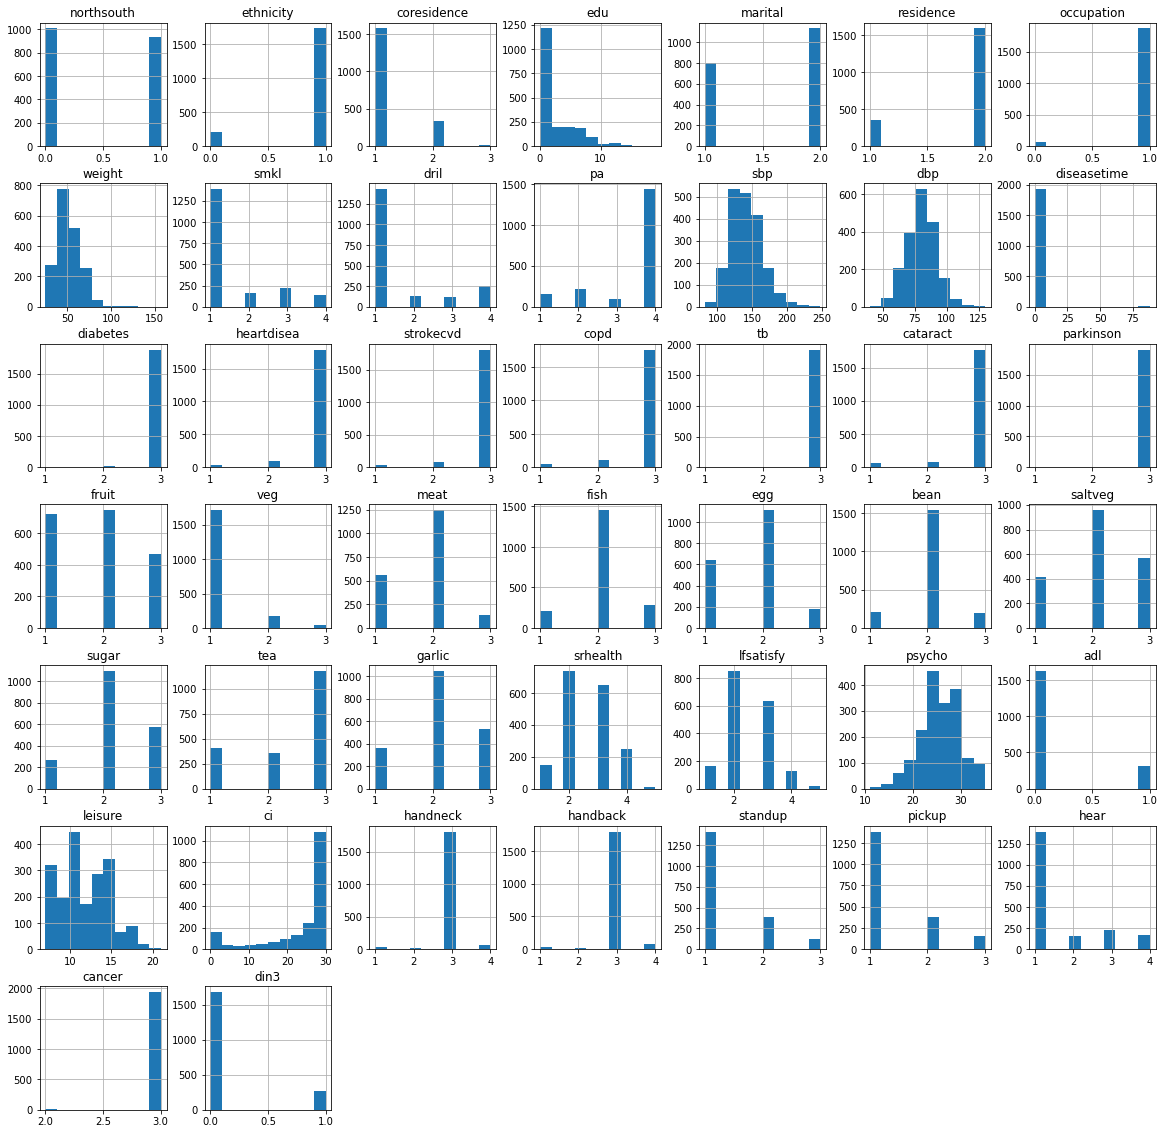

In [40]:
# Review the data distribution
data.hist(figsize=(20,20))
plt.show()

### 2.2 Missing Value Imputation

Try three methods of data imputation and find out the best
- KNN of fancyimpute package
- SoftImputation of fancyimpute package
- Median for numerical variables and mode for categorical variables


In [41]:
# Split dataset to X and y for missing value imputation

X_incomplete = data.drop('din3', axis=1)
X_incomplete.shape

(1939, 43)

In [42]:
y = data['din3']
y

0       0
1       0
2       0
3       0
4       0
       ..
1934    1
1935    0
1936    1
1937    0
1938    0
Name: din3, Length: 1939, dtype: int64

**Fill missing values by fancyimpute KNN**

In [43]:
# Use 5 nearest rows which have a feature to fill in each row's missing features

X_filled_knn5 = KNN(k=5).fit_transform(X_incomplete)

Imputing row 1/1939 with 0 missing, elapsed time: 1.400
Imputing row 101/1939 with 0 missing, elapsed time: 1.415
Imputing row 201/1939 with 0 missing, elapsed time: 1.415
Imputing row 301/1939 with 0 missing, elapsed time: 1.415
Imputing row 401/1939 with 0 missing, elapsed time: 1.415
Imputing row 501/1939 with 0 missing, elapsed time: 1.415
Imputing row 601/1939 with 3 missing, elapsed time: 1.415
Imputing row 701/1939 with 0 missing, elapsed time: 1.431
Imputing row 801/1939 with 0 missing, elapsed time: 1.431
Imputing row 901/1939 with 0 missing, elapsed time: 1.431
Imputing row 1001/1939 with 0 missing, elapsed time: 1.431
Imputing row 1101/1939 with 0 missing, elapsed time: 1.431
Imputing row 1201/1939 with 0 missing, elapsed time: 1.431
Imputing row 1301/1939 with 3 missing, elapsed time: 1.447
Imputing row 1401/1939 with 1 missing, elapsed time: 1.447
Imputing row 1501/1939 with 0 missing, elapsed time: 1.447
Imputing row 1601/1939 with 0 missing, elapsed time: 1.447
Imputing 

In [44]:
# Feature data scaling
cols = X_incomplete.columns  # Get columns name

min_max_scaler = MinMaxScaler()
X_knn5 = min_max_scaler.fit_transform(X_filled_knn5)
X_knn5 = pd.DataFrame(data = X_knn5, columns = cols)
X_knn5

,northsouth,ethnicity,coresidence,edu,marital,residence,occupation,weight,smkl,dril,...,psycho,adl,leisure,ci,handneck,handback,standup,pickup,hear,cancer
0,0.0,1.0,4.318745e-08,0.000000,1.0,0.0,1.0,0.151515,5.257224e-09,1.313790e-08,...,0.625000,0.0,0.000000,0.533333,0.666667,0.666667,0.0,4.205803e-08,0.000000,1.0
1,0.0,1.0,4.318745e-08,0.157895,0.0,0.0,1.0,0.227273,3.333333e-01,1.000000e+00,...,0.750000,0.0,0.285714,1.000000,0.666667,0.666667,0.0,4.205803e-08,0.000000,1.0
2,0.0,1.0,4.318745e-08,0.000000,1.0,0.0,1.0,0.416667,5.257224e-09,1.313790e-08,...,0.625000,0.0,0.285714,1.000000,0.666667,0.666667,0.0,4.205803e-08,0.000000,1.0
3,0.0,1.0,4.318745e-08,0.210526,1.0,0.0,0.0,0.151515,5.257224e-09,1.313790e-08,...,0.750000,0.0,0.214286,1.000000,0.666667,0.666667,0.0,5.000000e-01,0.000000,1.0
4,0.0,1.0,4.318745e-08,0.000000,1.0,0.0,1.0,0.113636,5.257224e-09,1.313790e-08,...,0.708333,0.0,0.214286,1.000000,0.666667,0.666667,0.0,4.205803e-08,0.666667,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1934,0.0,1.0,4.318745e-08,0.000000,1.0,1.0,1.0,0.125734,5.257224e-09,1.313790e-08,...,0.438554,0.0,0.000000,0.166667,0.666667,0.666667,0.5,5.000000e-01,0.333333,1.0
1935,0.0,1.0,4.318745e-08,0.000000,1.0,1.0,1.0,0.053030,5.257224e-09,1.313790e-08,...,0.375000,0.0,0.142857,0.766667,0.666667,0.666667,0.5,5.000000e-01,0.333333,1.0
1936,0.0,1.0,5.000000e-01,0.000000,1.0,1.0,1.0,0.053030,5.257224e-09,1.313790e-08,...,0.125000,0.0,0.000000,0.500000,0.666667,0.666667,0.5,5.000000e-01,0.333333,1.0
1937,0.0,1.0,5.000000e-01,0.000000,1.0,1.0,1.0,0.151515,5.257224e-09,1.313790e-08,...,0.666667,0.0,0.142857,0.766667,0.666667,0.666667,0.0,4.205803e-08,0.000000,1.0


**Fill missing values by fancyimpute SoftImpute**

In [45]:
X_filled_softimpute = SoftImpute().fit_transform(X_incomplete)

[SoftImpute] Max Singular Value of X_init = 7731.338801
[SoftImpute] Iter 1: observed MAE=0.798715 rank=6
[SoftImpute] Iter 2: observed MAE=0.802137 rank=6
[SoftImpute] Iter 3: observed MAE=0.804108 rank=6
[SoftImpute] Iter 4: observed MAE=0.804158 rank=6
[SoftImpute] Iter 5: observed MAE=0.803808 rank=6
[SoftImpute] Iter 6: observed MAE=0.803548 rank=6
[SoftImpute] Iter 7: observed MAE=0.803390 rank=6
[SoftImpute] Iter 8: observed MAE=0.803305 rank=6
[SoftImpute] Iter 9: observed MAE=0.803255 rank=6
[SoftImpute] Iter 10: observed MAE=0.803227 rank=6
[SoftImpute] Iter 11: observed MAE=0.803212 rank=6
[SoftImpute] Iter 12: observed MAE=0.803203 rank=6
[SoftImpute] Iter 13: observed MAE=0.803197 rank=6
[SoftImpute] Iter 14: observed MAE=0.803193 rank=6
[SoftImpute] Iter 15: observed MAE=0.803189 rank=6
[SoftImpute] Iter 16: observed MAE=0.803186 rank=6
[SoftImpute] Iter 17: observed MAE=0.803183 rank=6
[SoftImpute] Iter 18: observed MAE=0.803181 rank=6
[SoftImpute] Iter 19: observed MAE=

In [46]:
# Feature data scaling
cols = X_incomplete.columns  # Get columns name

min_max_scaler = MinMaxScaler()
X_softimpute = min_max_scaler.fit_transform(X_filled_softimpute)
X_softimpute = pd.DataFrame(data = X_softimpute, columns = cols)
X_softimpute

,northsouth,ethnicity,coresidence,edu,marital,residence,occupation,weight,smkl,dril,...,psycho,adl,leisure,ci,handneck,handback,standup,pickup,hear,cancer
0,0.0,1.0,0.063548,0.000000,1.0,0.0,1.0,0.151515,0.075113,0.044905,...,0.625000,0.0,0.000000,0.533333,0.666667,0.666667,0.053471,0.038629,0.000000,1.0
1,0.0,1.0,0.063548,0.157895,0.0,0.0,1.0,0.227273,0.383409,1.000000,...,0.750000,0.0,0.285714,1.000000,0.666667,0.666667,0.053471,0.038629,0.000000,1.0
2,0.0,1.0,0.063548,0.000000,1.0,0.0,1.0,0.416667,0.075113,0.044905,...,0.625000,0.0,0.285714,1.000000,0.666667,0.666667,0.053471,0.038629,0.000000,1.0
3,0.0,1.0,0.063548,0.210526,1.0,0.0,0.0,0.151515,0.075113,0.044905,...,0.750000,0.0,0.214286,1.000000,0.666667,0.666667,0.053471,0.519315,0.000000,1.0
4,0.0,1.0,0.063548,0.000000,1.0,0.0,1.0,0.113636,0.075113,0.044905,...,0.708333,0.0,0.214286,1.000000,0.666667,0.666667,0.053471,0.038629,0.666667,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1934,0.0,1.0,0.063548,0.000000,1.0,1.0,1.0,0.102943,0.075113,0.044905,...,0.342500,0.0,0.000000,0.166667,0.666667,0.666667,0.526736,0.519315,0.333333,1.0
1935,0.0,1.0,0.063548,0.000000,1.0,1.0,1.0,0.053030,0.075113,0.044905,...,0.375000,0.0,0.142857,0.766667,0.666667,0.666667,0.526736,0.519315,0.333333,1.0
1936,0.0,1.0,0.531774,0.000000,1.0,1.0,1.0,0.053030,0.075113,0.044905,...,0.125000,0.0,0.000000,0.500000,0.666667,0.666667,0.526736,0.519315,0.333333,1.0
1937,0.0,1.0,0.531774,0.000000,1.0,1.0,1.0,0.151515,0.075113,0.044905,...,0.666667,0.0,0.142857,0.766667,0.666667,0.666667,0.053471,0.038629,0.000000,1.0


**Fill missing values by median and mode**

In [47]:
print(X_incomplete.columns)

Index(['northsouth', 'ethnicity', 'coresidence', 'edu', 'marital', 'residence',
       'occupation', 'weight', 'smkl', 'dril', 'pa', 'sbp', 'dbp',
       'diseasetime', 'diabetes', 'heartdisea', 'strokecvd', 'copd', 'tb',
       'cataract', 'parkinson', 'fruit', 'veg', 'meat', 'fish', 'egg', 'bean',
       'saltveg', 'sugar', 'tea', 'garlic', 'srhealth', 'lfsatisfy', 'psycho',
       'adl', 'leisure', 'ci', 'handneck', 'handback', 'standup', 'pickup',
       'hear', 'cancer'],
      dtype='object')


In [48]:
# Collect numerical features
num_cols = ['edu', 'weight', 'sbp', 'dbp', 'diseasetime']

In [49]:
# Collect categorical features
cat_cols = ['northsouth', 'ethnicity', 'coresidence', 'marital', 'residence',
       'occupation', 'smkl', 'dril', 'pa',
       'diabetes', 'heartdisea', 'strokecvd', 'copd', 'tb',
       'cataract', 'parkinson', 'fruit', 'veg', 'meat', 'fish', 'egg', 'bean',
       'saltveg', 'sugar', 'tea', 'garlic', 'srhealth', 'lfsatisfy', 'psycho',
       'adl', 'leisure', 'ci', 'handneck', 'handback', 'standup', 'pickup',
       'hear', 'cancer']

In [50]:
X_filled_mm = X_incomplete.copy()

In [51]:
X_filled_mm

,northsouth,ethnicity,coresidence,edu,marital,residence,occupation,weight,smkl,dril,...,psycho,adl,leisure,ci,handneck,handback,standup,pickup,hear,cancer
0,0,1,1.0,0.0,2.0,1,1,45.0,1.0,1.0,...,26.0,0.0,7,16,3.0,3.0,1.0,1.0,1.0,3
1,0,1,1.0,3.0,1.0,1,1,55.0,2.0,4.0,...,29.0,0.0,11,30,3.0,3.0,1.0,1.0,1.0,3
2,0,1,1.0,0.0,2.0,1,1,80.0,1.0,1.0,...,26.0,0.0,11,30,3.0,3.0,1.0,1.0,1.0,3
3,0,1,1.0,4.0,2.0,1,0,45.0,1.0,1.0,...,29.0,0.0,10,30,3.0,3.0,1.0,2.0,1.0,3
4,0,1,1.0,0.0,2.0,1,1,40.0,1.0,1.0,...,28.0,0.0,10,30,3.0,3.0,1.0,1.0,3.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1934,0,1,1.0,0.0,2.0,2,1,NaN,1.0,1.0,...,NaN,0.0,7,5,3.0,3.0,2.0,2.0,2.0,3
1935,0,1,1.0,0.0,2.0,2,1,32.0,1.0,1.0,...,20.0,0.0,9,23,3.0,3.0,2.0,2.0,2.0,3
1936,0,1,2.0,0.0,2.0,2,1,32.0,1.0,1.0,...,14.0,0.0,7,15,3.0,3.0,2.0,2.0,2.0,3
1937,0,1,2.0,0.0,2.0,2,1,45.0,1.0,1.0,...,27.0,0.0,9,23,3.0,3.0,1.0,1.0,1.0,3


In [52]:
# Fill missing values in numerical features with their median.
for n in num_cols:
  X_filled_mm[n].fillna(X_filled_mm[n].median(), inplace=True)

In [53]:
# Fill missing values in categorical features with their mode.
for c in cat_cols:
  X_filled_mm[c].fillna(X_filled_mm[c].mode()[0], inplace=True)

In [54]:
# Feature data scaling
cols = X_filled_mm.columns  # Get columns name

min_max_scaler = MinMaxScaler()
X_mm = min_max_scaler.fit_transform(X_filled_mm)
X_mm = pd.DataFrame(data = X_filled_mm, columns = cols)
X_mm.shape

(1939, 43)

In [55]:
# Review if any null values after imputation

print(X_knn5.isna().sum().sum())
print(X_softimpute.isna().sum().sum())
print(X_mm.isna().sum().sum())

0
0
0


**Review model performance of each imputation method**

**KNN**

In [56]:
# Split data. Set 80% data as training; and 20% as test.
X_train, X_test, y_train, y_test = train_test_split(X_knn5, y, test_size = 0.2, random_state = 0)

models = {
    'xgboost': XGBClassifier(random_state=32),
    'adaboost': AdaBoostClassifier(random_state=32),
    'gradboost': GradientBoostingClassifier(random_state=32),
    'rf': RandomForestClassifier(random_state=32),
    'knn': KNeighborsClassifier(),
    'logreg': LogisticRegression(random_state=32),
    'nb': GaussianNB(),
    'svm': SVC(random_state=32),
    'dt': DecisionTreeClassifier(random_state=32),
    'mlp': MLPClassifier(random_state=32)
}

predict=[]
knn5_all_macroF1score = []
knn5_all_class1F1score = []

for model_name, model in models.items():
    clf = model
    clf.fit(X_train, y_train)
    predict = clf.predict(X_test)
    
    report = classification_report(y_test, predict, output_dict=True)
    class1F1score = round(report['1']['f1-score'], 3)
    knn5_all_class1F1score.append(class1F1score)
    macroF1score = round(report['macro avg']['f1-score'], 3)
    knn5_all_macroF1score.append(macroF1score)
    
    #print(report)
    #print('='*100)
print(knn5_all_class1F1score)
print('='*100)
print(knn5_all_macroF1score)

[0.348, 0.409, 0.409, 0.278, 0.366, 0.479, 0.466, 0.253, 0.291, 0.458]
[0.63, 0.664, 0.667, 0.598, 0.64, 0.703, 0.662, 0.584, 0.587, 0.691]


**Softimpute**

In [57]:
# Split data. Set 80% data as training; and 20% as test.
X_train, X_test, y_train, y_test = train_test_split(X_softimpute, y, test_size = 0.2, random_state = 0)

models = {
    'xgboost': XGBClassifier(random_state=32),
    'adaboost': AdaBoostClassifier(random_state=32),
    'gradboost': GradientBoostingClassifier(random_state=32),
    'rf': RandomForestClassifier(random_state=32),
    'knn': KNeighborsClassifier(),
    'logreg': LogisticRegression(random_state=32),
    'nb': GaussianNB(),
    'svm': SVC(random_state=32),
    'dt': DecisionTreeClassifier(random_state=32),
    'mlp': MLPClassifier(random_state=32)
}

predict=[]
softimpute_all_macroF1score = []
softimpute_all_class1F1score = []

for model_name, model in models.items():
    clf = model
    clf.fit(X_train, y_train)
    predict = clf.predict(X_test)
    
    report = classification_report(y_test, predict, output_dict=True)
    class1F1score = round(report['1']['f1-score'], 3)
    softimpute_all_class1F1score.append(class1F1score)
    macroF1score = round(report['macro avg']['f1-score'], 3)
    softimpute_all_macroF1score.append(macroF1score)
    
    #print(report)
    #print('='*100)
print(softimpute_all_class1F1score)
print('='*100)
print(softimpute_all_macroF1score)

[0.323, 0.344, 0.345, 0.253, 0.379, 0.463, 0.487, 0.272, 0.31, 0.449]
[0.615, 0.627, 0.631, 0.584, 0.646, 0.694, 0.679, 0.593, 0.595, 0.685]


**median/mode**

In [58]:
# Split data. Set 80% data as training; and 20% as test.
X_train, X_test, y_train, y_test = train_test_split(X_mm, y, test_size = 0.2, random_state = 0)

models = {
    'xgboost': XGBClassifier(random_state=32),
    'adaboost': AdaBoostClassifier(random_state=32),
    'gradboost': GradientBoostingClassifier(random_state=32),
    'rf': RandomForestClassifier(random_state=32),
    'knn': KNeighborsClassifier(),
    'logreg': LogisticRegression(random_state=32),
    'nb': GaussianNB(),
    'svm': SVC(random_state=32),
    'dt': DecisionTreeClassifier(random_state=32),
    'mlp': MLPClassifier(random_state=32)
}

predict=[]
mm_all_macroF1score = []
mm_all_class1F1score = []

for model_name, model in models.items():
    clf = model
    clf.fit(X_train, y_train)
    predict = clf.predict(X_test)
    
    report = classification_report(y_test, predict, output_dict=True)
    class1F1score = round(report['1']['f1-score'], 3)
    mm_all_class1F1score.append(class1F1score)
    macroF1score = round(report['macro avg']['f1-score'], 3)
    mm_all_macroF1score.append(macroF1score)
    
    #print(report)
    #print('='*100)
print(mm_all_class1F1score)
print('='*100)
print(mm_all_macroF1score)

[0.433, 0.433, 0.404, 0.296, 0.293, 0.463, 0.464, 0.032, 0.397, 0.396]
[0.676, 0.676, 0.661, 0.607, 0.605, 0.694, 0.651, 0.473, 0.645, 0.658]


**Comparison across all models by three imputation methods**

In [59]:
# List scores from three imputation methods together for better review

print(f'all class1 F1-score of knn5:       {knn5_all_class1F1score}')
print(f'all class1 F1-score of softimpute: {softimpute_all_class1F1score}')
print(f'all class1 F1-score of MedianMode: {mm_all_class1F1score}')
print('-'*100)
print(f'all macro F1-score of knn5:       {knn5_all_macroF1score}')
print(f'all macro F1-score of softimpute: {softimpute_all_macroF1score}')
print(f'all macro F1-score of MedianMode: {mm_all_macroF1score}')

print('='*100)
print(f'max class1 F1-score of knn5:  {max(knn5_all_class1F1score)}')
print(f'max class1 F1-score of softimpute:  {max(softimpute_all_class1F1score)}')
print(f'max class1 F1-score of MedianMode:  {max(mm_all_class1F1score)}')
print('-'*100)
print(f'max macro average F1-score of knn5:  {max(knn5_all_macroF1score)}')
print(f'max macro average F1-score of softimpute:  {max(softimpute_all_macroF1score)}')
print(f'max macro average F1-score of MedianMode:  {max(mm_all_macroF1score)}')


all class1 F1-score of knn5:       [0.348, 0.409, 0.409, 0.278, 0.366, 0.479, 0.466, 0.253, 0.291, 0.458]
all class1 F1-score of softimpute: [0.323, 0.344, 0.345, 0.253, 0.379, 0.463, 0.487, 0.272, 0.31, 0.449]
all class1 F1-score of MedianMode: [0.433, 0.433, 0.404, 0.296, 0.293, 0.463, 0.464, 0.032, 0.397, 0.396]
----------------------------------------------------------------------------------------------------
all macro F1-score of knn5:       [0.63, 0.664, 0.667, 0.598, 0.64, 0.703, 0.662, 0.584, 0.587, 0.691]
all macro F1-score of softimpute: [0.615, 0.627, 0.631, 0.584, 0.646, 0.694, 0.679, 0.593, 0.595, 0.685]
all macro F1-score of MedianMode: [0.676, 0.676, 0.661, 0.607, 0.605, 0.694, 0.651, 0.473, 0.645, 0.658]
max class1 F1-score of knn5:  0.479
max class1 F1-score of softimpute:  0.487
max class1 F1-score of MedianMode:  0.464
----------------------------------------------------------------------------------------------------
max macro average F1-score of knn5:  0.703
max m

>Note:
>- Different classifiers reaching their highest scores can be by the different imputation methods.
>- Will select XGBClassifier, LogisticRegression, GaussianNB, SVC and MLPClassifier to go further experiment based on the test results above.

## 3 Modeling and Evaluation

### 3.1 XGBClassifier

In [60]:
k_list = []
f1score_list = []
for k in np.arange(5, 30):
    print(f'k= {k}')
    print('-'*100)
    k_list.append(k)

    # apply SelectKBest class to extract top k best features
    skb = SelectKBest(score_func=chi2, k=k)
    fit = skb.fit(X_mm,y)
    df_scores = pd.DataFrame(fit.scores_)
    df_columns = pd.DataFrame(X_mm.columns)

    #concat two dataframes for better visualization
    featureScores = pd.concat([df_columns, df_scores], axis=1)
    featureScores.columns = ['Specs', 'Score']  # naming the dataframe column

    featureScores = featureScores.sort_values(by=['Score'], ascending=False)
    featureSelected = list(featureScores['Specs'][0:k])
    print(f'Feature Selected: {featureSelected}')
    print('-'*100)

    # Keep these selected features for further modelling
    X_mm_fs = pd.DataFrame(data = X_mm, columns = featureSelected)

    # Split data. Set 80% data as training; and 20% as test.
    X_train, X_test, y_train, y_test = train_test_split(X_mm_fs, y, test_size = 0.2, random_state = 0)

    # SMOTE training dataset
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_train, y_train)


    # Define the XGBoost classifier
    xgb = XGBClassifier(random_state=42)

    # Define the parameter grid to search
    params = {'learning_rate': uniform(0.01, 1),
              'max_depth': randint(1, 20),
              'n_estimators': randint(10, 200),
              
             }

    # Create the grid search object
    random_search = RandomizedSearchCV(xgb, 
                                       param_distributions=params, 
                                       n_iter=20, 
                                       cv=5,  
                                       scoring=make_scorer(f1_score, average='macro'), 
                                       random_state=32)
    random_search.fit(X_res, y_res)


    best_model = random_search.best_estimator_

    y_pred = best_model.predict(X_test)

    xgb_report = classification_report(y_test, y_pred, output_dict=True)
    f1score_list.append(xgb_report['macro avg']['f1-score'])

    print("Best parameters: ", random_search.best_estimator_)
    print('-'*100)
    print(xgb_report['macro avg']['f1-score'])
    print('-'*100)
    print(xgb_report['1']['f1-score'])
    print('='*100)

k= 5
----------------------------------------------------------------------------------------------------
Feature Selected: ['diseasetime', 'ci', 'edu', 'adl', 'leisure']
----------------------------------------------------------------------------------------------------
Best parameters:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.7195467128136194,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=176, n_jobs=None, num_parallel_tree=None,
 

Best parameters:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.6191091689913093,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=18, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=13, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
----------------------------------------------------------------------------------------------------
0.6420410190901994
----------------------------------------------------------------------------------------------------


Best parameters:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.17650012302602913,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=185, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
----------------------------------------------------------------------------------------------------
0.6701445243063606
---------------------------------------------------------------------------------------------------

Best parameters:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.17650012302602913,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=185, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
----------------------------------------------------------------------------------------------------
0.6547165013984235
---------------------------------------------------------------------------------------------------

Best parameters:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.6191091689913093,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=18, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=13, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
----------------------------------------------------------------------------------------------------
0.6528346167950129
----------------------------------------------------------------------------------------------------


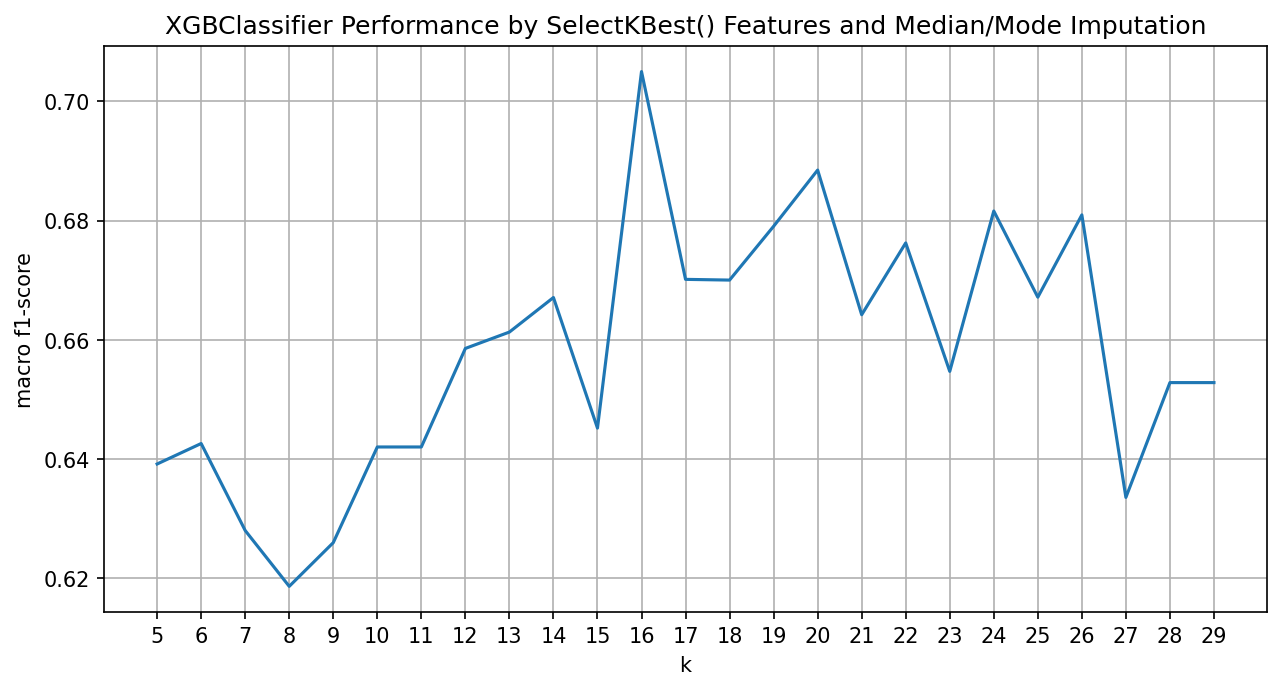

In [61]:
xgb_score_df = pd.DataFrame(data=f1score_list, index=k_list, columns=['f1score'])

plt.figure(figsize=(10,5), dpi=150)

plt.plot(xgb_score_df)
plt.xticks(xgb_score_df.index)
plt.xlabel('k')
plt.ylabel('macro f1-score')
plt.title('XGBClassifier Performance by SelectKBest() Features and Median/Mode Imputation')
plt.grid()
plt.show()

### 3.2 Logistic Regression

In [64]:
k_list = []
f1score_list = []
for k in np.arange(5, 30):
    print(f'k= {k}')
    print('-'*100)
    k_list.append(k)
    
    # apply SelectKBest class to extract top k best features
    skb = SelectKBest(score_func=chi2, k=k)
    fit = skb.fit(X_knn5,y)
    df_scores = pd.DataFrame(fit.scores_)
    df_columns = pd.DataFrame(X_knn5.columns)

    #concat two dataframes for better visualization
    featureScores = pd.concat([df_columns, df_scores], axis=1)
    featureScores.columns = ['Specs', 'Score']  # naming the dataframe column

    featureScores = featureScores.sort_values(by=['Score'], ascending=False)
    featureSelected = list(featureScores['Specs'][0:k])
   
    print(f'Feature Selected: {featureSelected}')
    print('='*100)

    # Keep these selected features for further modelling
    X_knn5_fs = pd.DataFrame(data = X_knn5, columns = featureSelected)

    # Split data. Set 80% data as training; and 20% as test.
    X_train, X_test, y_train, y_test = train_test_split(X_knn5_fs, y, test_size = 0.2, random_state = 0)

    # SMOTE training dataset
    #sm = SMOTE(random_state=32)
    #X_res, y_res = sm.fit_resample(X_train, y_train)

    # define the model
    lr = LogisticRegression(random_state = 32)

    # Define the hyperparameters to be tuned
    params = {'penalty': ['l1', 'l2', 'elasticnet', None],
              'C': loguniform(1e0, 1e3),
              'class_weight':['balanced', None],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
               
              }

    # Use RandomizedSearchCV to find the best hyperparameters
    random_search = RandomizedSearchCV(lr, 
                                       param_distributions=params, 
                                       n_iter=50, 
                                       cv=5,  
                                       scoring=make_scorer(f1_score, average='macro'), 
                                       random_state=32)
    random_search.fit(X_train, y_train)

    best_model = random_search.best_estimator_

    y_pred = best_model.predict(X_test)

    lr_report = classification_report(y_test, y_pred, output_dict=True)
    f1score_list.append(lr_report['macro avg']['f1-score'])

    print("Best parameters: ", random_search.best_estimator_)
    print('-'*100)
    print(lr_report['macro avg']['f1-score'])
    print('-'*100)
    print(lr_report['1']['f1-score'])
    print('='*100)

k= 5
----------------------------------------------------------------------------------------------------
Feature Selected: ['adl', 'hear', 'standup', 'pickup', 'marital']
Best parameters:  LogisticRegression(C=2.010294483625662, class_weight='balanced',
                   random_state=32, solver='saga')
----------------------------------------------------------------------------------------------------
0.6887149001981538
----------------------------------------------------------------------------------------------------
0.5146198830409358
k= 6
----------------------------------------------------------------------------------------------------
Feature Selected: ['adl', 'hear', 'standup', 'pickup', 'marital', 'ci']
Best parameters:  LogisticRegression(C=1.274798441560498, class_weight='balanced',
                   random_state=32, solver='newton-cg')
----------------------------------------------------------------------------------------------------
0.6912930530392354
-----------------

Best parameters:  LogisticRegression(C=11.855918380869866, random_state=32, solver='liblinear')
----------------------------------------------------------------------------------------------------
0.6255990056098
----------------------------------------------------------------------------------------------------
0.3370786516853933
k= 17
----------------------------------------------------------------------------------------------------
Feature Selected: ['adl', 'hear', 'standup', 'pickup', 'marital', 'ci', 'leisure', 'diseasetime', 'smkl', 'edu', 'veg', 'pa', 'dril', 'weight', 'saltveg', 'sugar', 'tea']
Best parameters:  LogisticRegression(C=11.855918380869866, random_state=32, solver='liblinear')
----------------------------------------------------------------------------------------------------
0.6310494970221711
----------------------------------------------------------------------------------------------------
0.3448275862068966
k= 18
-----------------------------------------------

Best parameters:  LogisticRegression(C=11.855918380869866, random_state=32, solver='liblinear')
----------------------------------------------------------------------------------------------------
0.623461309270452
----------------------------------------------------------------------------------------------------
0.3294117647058823
k= 27
----------------------------------------------------------------------------------------------------
Feature Selected: ['adl', 'hear', 'standup', 'pickup', 'marital', 'ci', 'leisure', 'diseasetime', 'smkl', 'edu', 'veg', 'pa', 'dril', 'weight', 'saltveg', 'sugar', 'tea', 'northsouth', 'garlic', 'fruit', 'psycho', 'egg', 'srhealth', 'handback', 'fish', 'sbp', 'meat']
Best parameters:  LogisticRegression(C=11.855918380869866, random_state=32, solver='liblinear')
----------------------------------------------------------------------------------------------------
0.6701050774043475
--------------------------------------------------------------------------

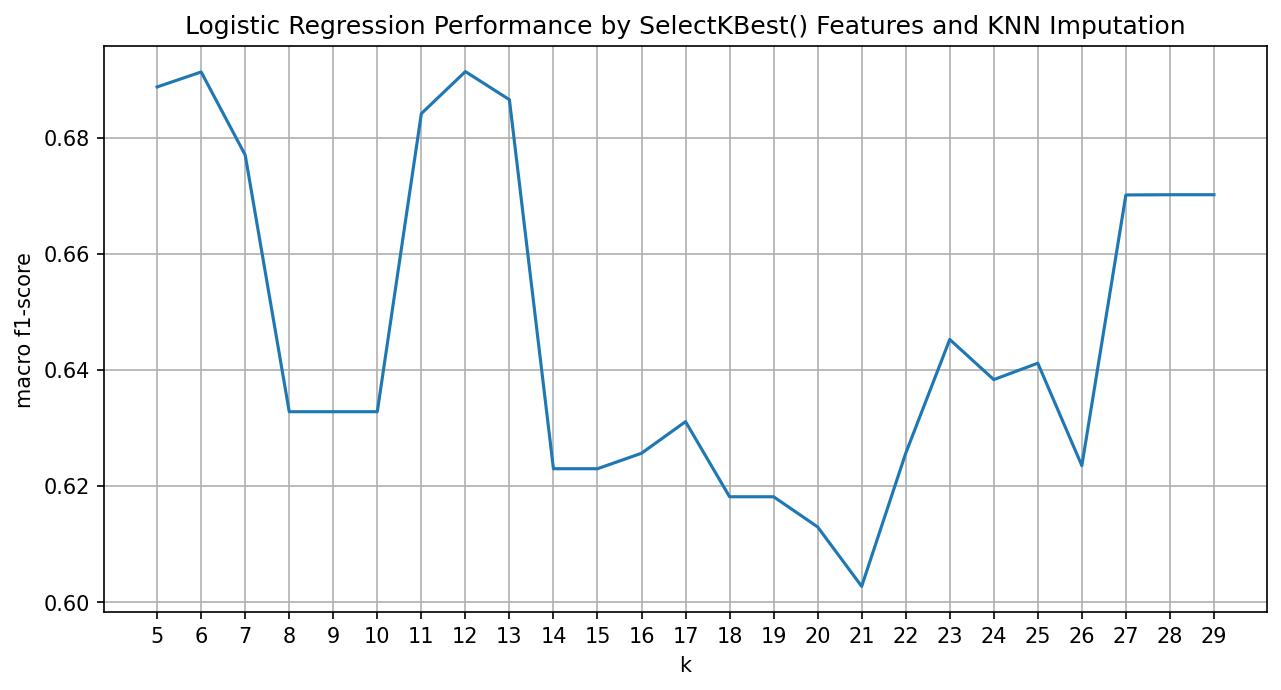

In [65]:
lr_score_df = pd.DataFrame(data=f1score_list, index=k_list, columns=['f1score'])

plt.figure(figsize=(10,5), dpi=150)

plt.plot(lr_score_df)
plt.xticks(lr_score_df.index)
plt.xlabel('k')
plt.ylabel('macro f1-score')
plt.title('Logistic Regression Performance by SelectKBest() Features and KNN Imputation')
plt.grid()
plt.show()

### 3.3 GaussianNB

In [60]:
k_list = []
f1score_list = []
for k in np.arange(5, 30):
    print(f'k= {k}')
    print('-'*100)
    k_list.append(k)
    
    # apply SelectKBest class to extract top k best features
    skb = SelectKBest(score_func=chi2, k=k)
    fit = skb.fit(X_softimpute,y)
    df_scores = pd.DataFrame(fit.scores_)
    df_columns = pd.DataFrame(X_softimpute.columns)

    #concat two dataframes for better visualization
    featureScores = pd.concat([df_columns, df_scores], axis=1)
    featureScores.columns = ['Specs', 'Score']  # naming the dataframe column

    featureScores = featureScores.sort_values(by=['Score'], ascending=False)
    featureSelected = list(featureScores['Specs'][0:k])
        
    print(f'Feature Selected: {featureSelected}')
    print('-'*100)

    # Keep these selected features for further modelling
    X_softimpute_fs = pd.DataFrame(data = X_softimpute, columns = featureSelected)

    # Split data. Set 80% data as training; and 20% as test.
    X_train, X_test, y_train, y_test = train_test_split(X_softimpute_fs, y, test_size = 0.2, random_state = 0)

    # SMOTE training dataset
    #sm = SMOTE(random_state=32)
    #X_res, y_res = sm.fit_resample(X_train, y_train)

    # define the model
    gnb = GaussianNB()

    # Define the hyperparameters to be tuned
    params = {'var_smoothing': np.logspace(0,-15, num=100)
              
              }

    
    # Use RandomizedSearchCV to find the best hyperparameters
    random_search = RandomizedSearchCV(gnb, 
                                       param_distributions=params, 
                                       n_iter=50, 
                                       cv=5,  
                                       scoring=make_scorer(f1_score, average='macro'), 
                                       random_state=32)
    random_search.fit(X_train, y_train)

    best_model = random_search.best_estimator_

    y_pred = best_model.predict(X_test)

    gnb_report = classification_report(y_test, y_pred, output_dict=True)
    f1score_list.append(gnb_report['macro avg']['f1-score'])

    print("Best parameters: ", random_search.best_estimator_)
    print('-'*100)
    print(gnb_report['macro avg']['f1-score'])
    print('-'*100)
    print(gnb_report['1']['f1-score'])
    print('='*100)

k= 5
----------------------------------------------------------------------------------------------------
Feature Selected: ['adl', 'hear', 'pickup', 'standup', 'marital']
----------------------------------------------------------------------------------------------------
Best parameters:  GaussianNB(var_smoothing=0.08697490026177834)
----------------------------------------------------------------------------------------------------
0.668798746477391
----------------------------------------------------------------------------------------------------
0.45112781954887216
k= 6
----------------------------------------------------------------------------------------------------
Feature Selected: ['adl', 'hear', 'pickup', 'standup', 'marital', 'ci']
----------------------------------------------------------------------------------------------------
Best parameters:  GaussianNB(var_smoothing=0.06135907273413173)
--------------------------------------------------------------------------------

Best parameters:  GaussianNB(var_smoothing=0.001873817422860383)
----------------------------------------------------------------------------------------------------
0.6669880794701987
----------------------------------------------------------------------------------------------------
0.46357615894039744
k= 17
----------------------------------------------------------------------------------------------------
Feature Selected: ['adl', 'hear', 'pickup', 'standup', 'marital', 'ci', 'leisure', 'diseasetime', 'edu', 'smkl', 'pa', 'weight', 'dril', 'veg', 'psycho', 'saltveg', 'sugar']
----------------------------------------------------------------------------------------------------
Best parameters:  GaussianNB(var_smoothing=0.001873817422860383)
----------------------------------------------------------------------------------------------------
0.6694355697550587
----------------------------------------------------------------------------------------------------
0.4666666666666667
k= 18
-

Best parameters:  GaussianNB(var_smoothing=1.0)
----------------------------------------------------------------------------------------------------
0.6773120425815036
----------------------------------------------------------------------------------------------------
0.4444444444444444
k= 27
----------------------------------------------------------------------------------------------------
Feature Selected: ['adl', 'hear', 'pickup', 'standup', 'marital', 'ci', 'leisure', 'diseasetime', 'edu', 'smkl', 'pa', 'weight', 'dril', 'veg', 'psycho', 'saltveg', 'sugar', 'tea', 'northsouth', 'garlic', 'fruit', 'egg', 'lfsatisfy', 'handback', 'fish', 'sbp', 'meat']
----------------------------------------------------------------------------------------------------
Best parameters:  GaussianNB(var_smoothing=0.7054802310718643)
----------------------------------------------------------------------------------------------------
0.6886403999210683
----------------------------------------------------

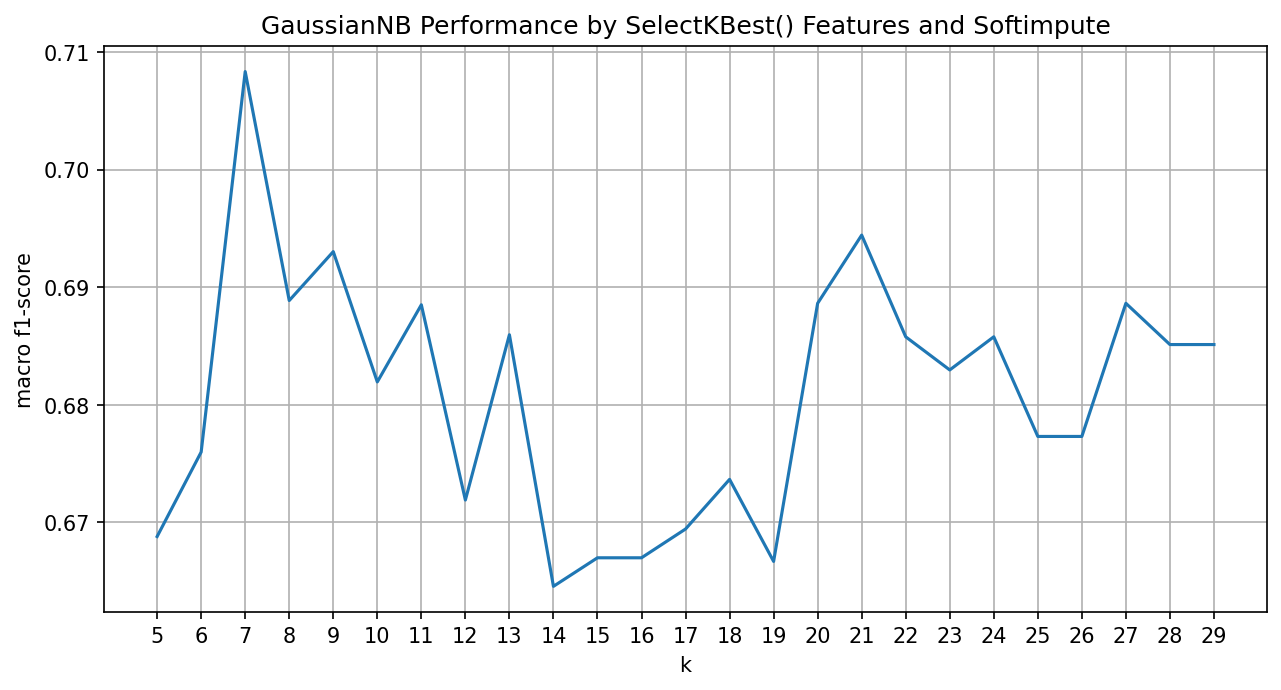

In [61]:
gnb_score_df = pd.DataFrame(data=f1score_list, index=k_list, columns=['f1score'])

plt.figure(figsize=(10,5), dpi=150)

plt.plot(gnb_score_df)
plt.xticks(gnb_score_df.index)
plt.xlabel('k')
plt.ylabel('macro f1-score')
plt.title('GaussianNB Performance by SelectKBest() Features and Softimpute')
plt.grid()
plt.show()

### 3.4 SVM

In [68]:
k_list = []
f1score_list = []
for k in np.arange(5, 30):
    print(f'k= {k}')
    print('-'*100)
    k_list.append(k)
    
    # apply SelectKBest class to extract top k best features
    skb = SelectKBest(score_func=chi2, k=k)
    fit = skb.fit(X_softimpute,y)
    df_scores = pd.DataFrame(fit.scores_)
    df_columns = pd.DataFrame(X_softimpute.columns)

    #concat two dataframes for better visualization
    featureScores = pd.concat([df_columns, df_scores], axis=1)
    featureScores.columns = ['Specs', 'Score']  # naming the dataframe column

    featureScores = featureScores.sort_values(by=['Score'], ascending=False)
    featureSelected = list(featureScores['Specs'][0:k])
        
    print(f'Feature Selected: {featureSelected}')
    print('-'*100)

    # Keep these selected features for further modelling
    X_softimpute_fs = pd.DataFrame(data = X_softimpute, columns = featureSelected)

    # Split data. Set 80% data as training; and 20% as test.
    X_train, X_test, y_train, y_test = train_test_split(X_softimpute_fs, y, test_size = 0.2, random_state = 0)

    # SMOTE training dataset
    #sm = SMOTE(random_state=32)
    #X_res, y_res = sm.fit_resample(X_train, y_train)

    # define the model
    svm = SVC(random_state=32)

    # Define the hyperparameters to be tuned
    params = {'C': loguniform(1e0, 1e3), 
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma': loguniform(1e-4, 1e-1),
              'class_weight':['balanced', None]
              }

    
    # Use RandomizedSearchCV to find the best hyperparameters
    random_search = RandomizedSearchCV(svm, 
                                       param_distributions=params, 
                                       n_iter=50, 
                                       cv=5,  
                                       scoring=make_scorer(f1_score, average='macro'), 
                                       random_state=32)
    random_search.fit(X_train, y_train)

    best_model = random_search.best_estimator_

    y_pred = best_model.predict(X_test)

    svm_report = classification_report(y_test, y_pred, output_dict=True)
    f1score_list.append(svm_report['macro avg']['f1-score'])

    print("Best parameters: ", random_search.best_estimator_)
    print('-'*100)
    print(svm_report['macro avg']['f1-score'])
    print('-'*100)
    print(svm_report['1']['f1-score'])
    print('='*100)

k= 5
----------------------------------------------------------------------------------------------------
Feature Selected: ['adl', 'hear', 'pickup', 'standup', 'marital']
----------------------------------------------------------------------------------------------------
Best parameters:  SVC(C=478.81153291333464, class_weight='balanced', gamma=0.014253895547130524,
    kernel='poly', random_state=32)
----------------------------------------------------------------------------------------------------
0.6736592123490995
----------------------------------------------------------------------------------------------------
0.45161290322580644
k= 6
----------------------------------------------------------------------------------------------------
Feature Selected: ['adl', 'hear', 'pickup', 'standup', 'marital', 'ci']
----------------------------------------------------------------------------------------------------
Best parameters:  SVC(C=1.274798441560498, class_weight='balanced', gamma=

Best parameters:  SVC(C=62.406667426631955, class_weight='balanced', gamma=0.0002392511450613574,
    kernel='sigmoid', random_state=32)
----------------------------------------------------------------------------------------------------
0.6934623740865099
----------------------------------------------------------------------------------------------------
0.5180722891566264
k= 16
----------------------------------------------------------------------------------------------------
Feature Selected: ['adl', 'hear', 'pickup', 'standup', 'marital', 'ci', 'leisure', 'diseasetime', 'edu', 'smkl', 'pa', 'weight', 'dril', 'veg', 'psycho', 'saltveg']
----------------------------------------------------------------------------------------------------
Best parameters:  SVC(C=1.1091746422084292, class_weight='balanced', gamma=0.08726519859732469,
    kernel='sigmoid', random_state=32)
----------------------------------------------------------------------------------------------------
0.688260675494

Best parameters:  SVC(C=1.8998960530220907, class_weight='balanced', gamma=0.0022739969345464874,
    kernel='sigmoid', random_state=32)
----------------------------------------------------------------------------------------------------
0.7008116883116884
----------------------------------------------------------------------------------------------------
0.525
k= 26
----------------------------------------------------------------------------------------------------
Feature Selected: ['adl', 'hear', 'pickup', 'standup', 'marital', 'ci', 'leisure', 'diseasetime', 'edu', 'smkl', 'pa', 'weight', 'dril', 'veg', 'psycho', 'saltveg', 'sugar', 'tea', 'northsouth', 'garlic', 'fruit', 'egg', 'lfsatisfy', 'handback', 'fish', 'sbp']
----------------------------------------------------------------------------------------------------
Best parameters:  SVC(C=1.8998960530220907, class_weight='balanced', gamma=0.0022739969345464874,
    kernel='sigmoid', random_state=32)
------------------------------

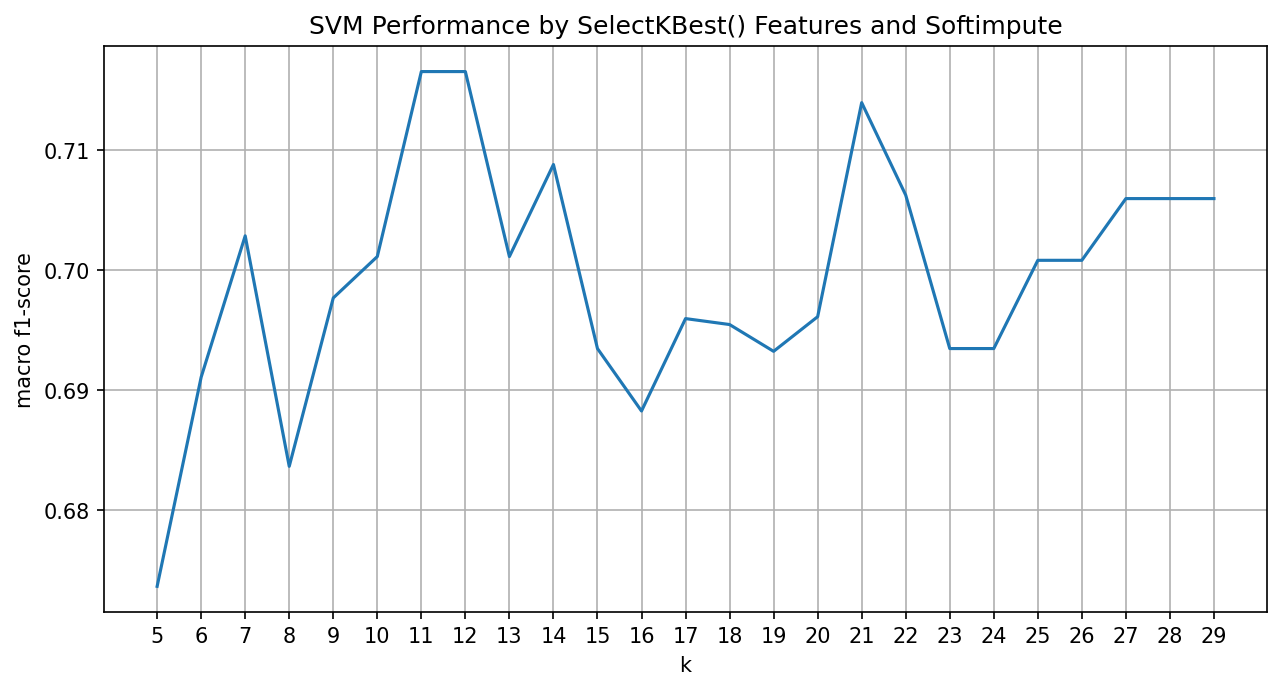

In [69]:
svm_score_df = pd.DataFrame(data=f1score_list, index=k_list, columns=['f1score'])

plt.figure(figsize=(10,5), dpi=150)

plt.plot(svm_score_df)
plt.xticks(svm_score_df.index)
plt.xlabel('k')
plt.ylabel('macro f1-score')
plt.title('SVM Performance by SelectKBest() Features and Softimpute')
plt.grid()
plt.show()

### 3.5 MLPClassifier

In [70]:
k_list = []
f1score_list = []
for k in np.arange(5, 30):
    print(f'k= {k}')
    print('-'*100)
    k_list.append(k)
    
    # apply SelectKBest class to extract top k best features
    skb = SelectKBest(score_func=chi2, k=k)
    fit = skb.fit(X_knn5,y)
    df_scores = pd.DataFrame(fit.scores_)
    df_columns = pd.DataFrame(X_knn5.columns)

    #concat two dataframes for better visualization
    featureScores = pd.concat([df_columns, df_scores], axis=1)
    featureScores.columns = ['Specs', 'Score']  # naming the dataframe column

    featureScores = featureScores.sort_values(by=['Score'], ascending=False)
    featureSelected = list(featureScores['Specs'][0:k])
        
    print(f'Feature Selected: {featureSelected}')
    print('-'*100)

    # Keep these selected features for further modelling
    X_knn5_fs = pd.DataFrame(data = X_knn5, columns = featureSelected)

    # Split data. Set 80% data as training; and 20% as test.
    X_train, X_test, y_train, y_test = train_test_split(X_knn5_fs, y, test_size = 0.2, random_state = 0)

    # SMOTE training dataset
    #sm = SMOTE(random_state=32)
    #X_res, y_res = sm.fit_resample(X_train, y_train)

    # define the model
    mlp = MLPClassifier()

    # Define the hyperparameters to be tuned
    params = {'hidden_layer_sizes': [(100,), (200,), (1024,), (100,100), (200,200), (1024,1024)],
              'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'solver': ['lbfgs', 'sgd', 'adam'],          
              'alpha': [0.00001, 0.0001, 0.001, 0.01]
              }

    
    # Use RandomizedSearchCV to find the best hyperparameters
    random_search = RandomizedSearchCV(mlp, 
                                       param_distributions=params, 
                                       n_iter=20, 
                                       cv=5,  
                                       scoring=make_scorer(f1_score, average='macro'), 
                                       random_state=32)
    random_search.fit(X_train, y_train)

    best_model = random_search.best_estimator_

    y_pred = best_model.predict(X_test)

    mlp_report = classification_report(y_test, y_pred, output_dict=True)
    f1score_list.append(mlp_report['macro avg']['f1-score'])

    print("Best parameters: ", random_search.best_estimator_)
    print('-'*100)
    print(mlp_report['macro avg']['f1-score'])
    print('-'*100)
    print(mlp_report['1']['f1-score'])
    print('='*100)

k= 5
----------------------------------------------------------------------------------------------------
Feature Selected: ['adl', 'hear', 'standup', 'pickup', 'marital']
----------------------------------------------------------------------------------------------------
Best parameters:  MLPClassifier(activation='identity', hidden_layer_sizes=(100, 100))
----------------------------------------------------------------------------------------------------
0.6452073473971285
----------------------------------------------------------------------------------------------------
0.3736263736263736
k= 6
----------------------------------------------------------------------------------------------------
Feature Selected: ['adl', 'hear', 'standup', 'pickup', 'marital', 'ci']
----------------------------------------------------------------------------------------------------
Best parameters:  MLPClassifier(hidden_layer_sizes=(100, 100))
-----------------------------------------------------------

Best parameters:  MLPClassifier(activation='identity', hidden_layer_sizes=(100, 100))
----------------------------------------------------------------------------------------------------
0.6181038653387384
----------------------------------------------------------------------------------------------------
0.3218390804597701
k= 17
----------------------------------------------------------------------------------------------------
Feature Selected: ['adl', 'hear', 'standup', 'pickup', 'marital', 'ci', 'leisure', 'diseasetime', 'smkl', 'edu', 'veg', 'pa', 'dril', 'weight', 'saltveg', 'sugar', 'tea']
----------------------------------------------------------------------------------------------------
Best parameters:  MLPClassifier(activation='identity', alpha=0.001, hidden_layer_sizes=(1024,))
----------------------------------------------------------------------------------------------------
0.6255990056098
----------------------------------------------------------------------------------

Best parameters:  MLPClassifier(activation='identity', hidden_layer_sizes=(100, 100))
----------------------------------------------------------------------------------------------------
0.5890975976812887
----------------------------------------------------------------------------------------------------
0.2597402597402597
k= 27
----------------------------------------------------------------------------------------------------
Feature Selected: ['adl', 'hear', 'standup', 'pickup', 'marital', 'ci', 'leisure', 'diseasetime', 'smkl', 'edu', 'veg', 'pa', 'dril', 'weight', 'saltveg', 'sugar', 'tea', 'northsouth', 'garlic', 'fruit', 'psycho', 'egg', 'srhealth', 'handback', 'fish', 'sbp', 'meat']
----------------------------------------------------------------------------------------------------
Best parameters:  MLPClassifier(activation='identity', alpha=1e-05, hidden_layer_sizes=(1024,))
----------------------------------------------------------------------------------------------------
0

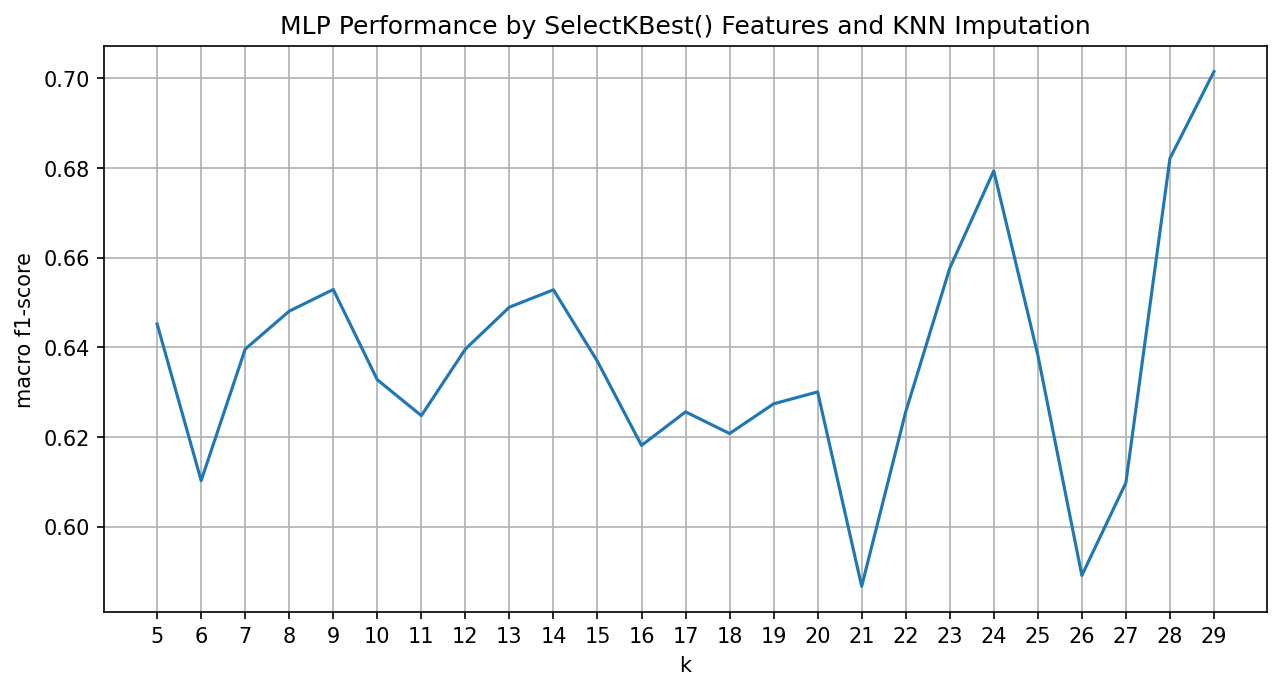

In [71]:
mlp_score_df = pd.DataFrame(data=f1score_list, index=k_list, columns=['f1score'])

plt.figure(figsize=(10,5), dpi=150)

plt.plot(mlp_score_df)
plt.xticks(mlp_score_df.index)
plt.xlabel('k')
plt.ylabel('macro f1-score')
plt.title('MLP Performance by SelectKBest() Features and KNN Imputation')
plt.grid()
plt.show()

## 4 Summary

### 4.1 Compare the highest score from these five models

**1. XGBClassifier reaches its best score 0.705 when 16 features are selected.**

k= 16

Feature Selected: ['diseasetime', 'ci', 'edu', 'adl', 'leisure', 'weight', 'hear', 'pickup', 'standup', 'sbp', 'marital', 'smkl', 'pa', 'dbp', 'psycho', 'dril']

<font color = blue>
    macro_F1score: 0.704984511405238 <br>
    Class1_F1score: 0.4905660377358491
</font>


**2. LogisticRegression reaches its best score 0.691 when 12 features are selected.**

k= 12

Feature Selected: ['adl', 'hear', 'standup', 'pickup', 'marital', 'ci', 'leisure', 'diseasetime', 'smkl', 'edu', 'veg', 'pa']

<font color = blue>
    macro_F1score: 0.6913636363636363 <br>
    Class1_F1score: 0.5227272727272727
</font>

**3. GaussianNB reaches its best score 0.708 when 7 features are selected.**

k= 7

Feature Selected: ['adl', 'hear', 'pickup', 'standup', 'marital', 'ci', 'leisure']

<font color = blue>
    macro_F1score: 0.7083559527289431 <br>
    Class1_F1score: 0.5324675324675325
</font>

**4. SVC reaches its best score 0.717 when 11 features are selected.**

k= 11

Feature Selected: ['adl', 'hear', 'pickup', 'standup', 'marital', 'ci', 'leisure', 'diseasetime', 'edu', 'smkl', 'pa']

<font color = blue>
    macro_F1score: 0.7165303896155887 <br>
    Class1_F1score: 0.5521472392638037
</font>

**5. MLPClassifier reaches its best score 0.702 when 29 features are selected.**

k= 29

Feature Selected: ['adl', 'hear', 'standup', 'pickup', 'marital', 'ci', 'leisure', 'diseasetime', 'smkl', 'edu', 'veg', 'pa', 'dril', 'weight', 'saltveg', 'sugar', 'tea', 'northsouth', 'garlic', 'fruit', 'psycho', 'egg', 'srhealth', 'handback', 'fish', 'sbp', 'meat', 'coresidence', 'occupation']

<font color = blue>
    macro_F1score: 0.7015384615384616 <br>
    Class1_F1score: 0.48000000000000004
</font>


>Note:
>- In comparison, SVC model outperforms the others on both macro F1-score and Class1 F1-score. GaussianNB is right behind it.
>- However, GaussianNB could be the most efficient model for this task. As it reaches its best performance with only 7 features.
    

### 4.2 Review the selected features from the best model

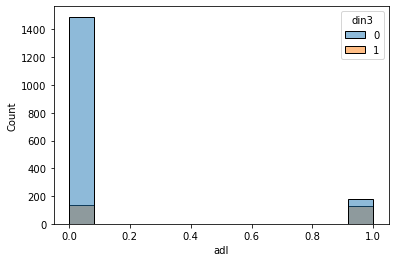

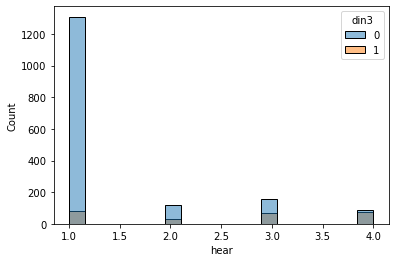

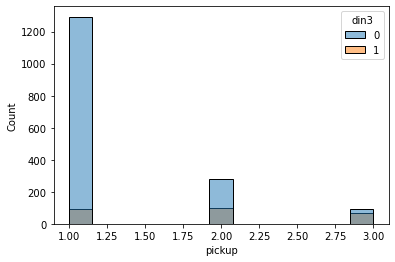

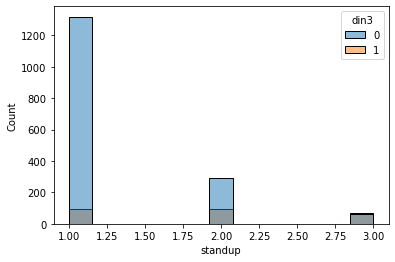

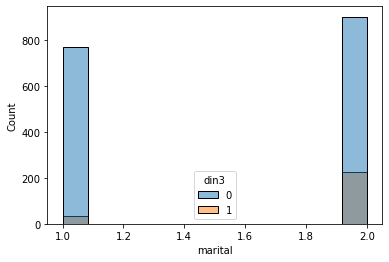

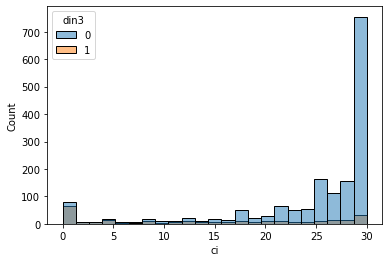

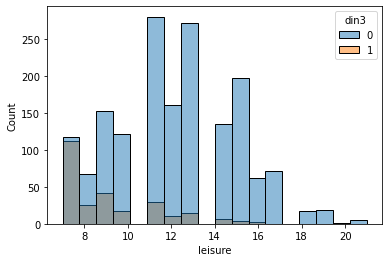

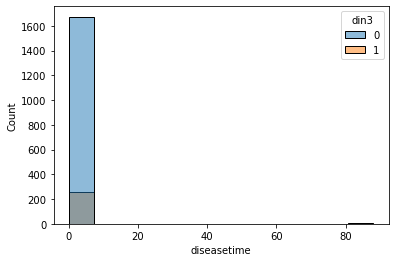

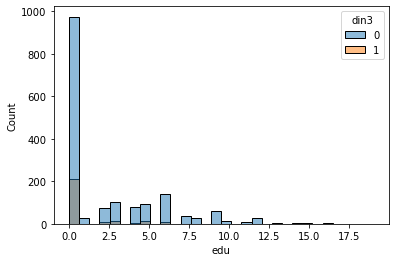

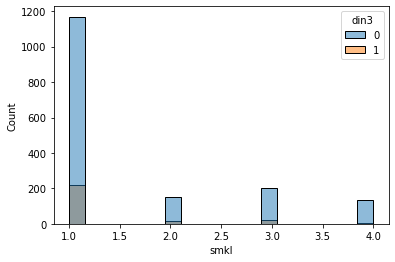

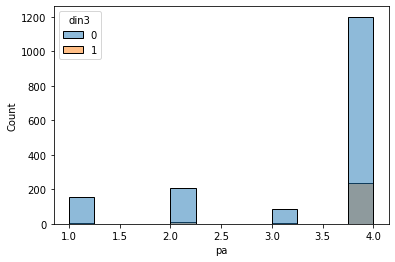

In [65]:
# The selected features of the best model: ['adl', 'hear', 'pickup', 'standup', 'marital', 'ci', 'leisure', 'diseasetime', 'edu', 'smkl', 'pa']

fs = ['adl', 'hear', 'pickup', 'standup', 'marital', 'ci', 'leisure', 'diseasetime', 'edu', 'smkl', 'pa']

for f in fs:    
    sns.histplot(data=data, x=data[f], hue="din3")
    plt.show()

>Conclusion:
>- 'adl', 'hear', 'pickup', 'standup', 'marital', 'ci', 'leisure', 'diseasetime', 'edu', 'smkl', 'pa' are the critical factors that impact on longevity.
>- adl: Doing more activities of daily living leads to long life in general.
>- standup, pickup, hear: Better capability of these ability leads to long life in general.
>- marital: married people are long life in general;
>- ci: Higher cognition results in long life in general.
>- leisure: Spending more time on leisure activities leads to long life in general.
>- diseasetime: longer disease time could reduce life time in general.
>- edu: higher education leads to long life in general.
>- smkl: having or not having smoking people can be found in both long life and short life people.
>- pa: having regularly physical activity leads to long life in general.

**Regardless of age and gender, based on the results, it is obviously that elder people who have more daily living activities, more leisure activities and regularly physical activities, good education and higher cognition, and less smoking and disease time could enjoy longer life.**
